# Optimale Nutzung einer Wärmepumpe mit variablem Stromvertrag unter Berücksichtigung eines Pufferspeichers

- nachfolgende Integration einer PV-Anlage, Batterie & einem fixen Strompreis zur Deckung des Haushaltsbedarfs

In [60]:
#imports
import pulp as p
from pulp import value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from demandlib import bdew
from geopy.geocoders import Nominatim
import requests
import os
import logging
from bs4 import BeautifulSoup
from datetime import datetime
import configparser
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import calendar
import tkinter as tk
from tkinter import ttk
from entsoe import EntsoePandasClient

In [61]:
p_max = 10  # Maximale Leistung Wärmepumpe
s_max = 7  # Maximale Kapazität Pufferspeicher
s_laden = 3  # Maximale Ladeleistung Pufferspeicher
s_entladen = 1  # Maximale Entladeleistung Pufferspeicher
eta_puf = 0.95  # Wirkungsgrad Pufferspeicher beim Einspeisen
loss_puf = 0.02  # Wärmeverlust pro Zeiteinheit in Prozent
dt = 1  # Stunde
S_start = 0  # Anfangsfüllstand des Wärmespeichers
U_wand = 0.3  # Wärmedurchgangskoeffizient Wand (W/m²K)
A_wand = 90  # Fläche der Wand (m²)
U_fenster = 1.2  # Wärmedurchgangskoeffizient Fenster (W/m²K)
A_fenster = 22  # Fläche der Fenster (m²)
V_raum = 340  # Raumvolumen (m³)
luftwechselrate = 0.5  # Luftwechselrate (1/h)
rho = 1.2  # Dichte der Luft (kg/m³)
c = 1000  # Wärmekapazität der Luft (J/kgK)
temp_innen = 20  # Gewünschte Innentemperatur in Grad
cop_vorfaktor = 0.4  # COP-Vorfaktor
a = 1.5  # Steigung Heizkurve
b = 30  # Basiswert
P_bat = 10  # Maximale Lade- & Entladeleistung Batterie in kW
E_bat = 20  # Maximale Kapazität Batterie in kW
eta_bat = 0.9  # Wirkungsgrad Batterie
c_pur = 0.2  # Strompreis in EUR/kWh
c_feedin = 0.018  # Einspeisevergütung EUR/kWh Einspeisen
l_start = 0  # Anfangsfüllstand der Batterie in kW
yearly_demand = 3000  # Jährlicher Energiebedarf (kWh)
pv_installed_power = 10  # Installierte PV-Leistung (kWp)
selected_location = "Universitätsstraße 12, 45141 Essen"  # Standort
selected_year = 2019  # Jahr der Daten
buy_pump = 6000  # Anschaffungskosten Wärmepumpe in Euro
buy_storage = 7800  # Anschaffungskosten Pufferspeicher in Euro
heating_bill = 730  # Jährliche Heizkostenrechnung

In [63]:
# Default-Werte mit Kommentaren
default_values = {
    "p_max": (10, "Maximale Leistung Wärmepumpe"),
    "s_max": (7, "Maximale Kapazität Pufferspeicher"),
    "s_laden": (3, "Maximale Ladeleistung Pufferspeicher"),
    "s_entladen": (1, "Maximale Entladeleistung Pufferspeicher"),
    "eta_puf": (0.95, "Wirkungsgrad Pufferspeicher beim Einspeisen"),
    "loss_puf": (0.02, "Wärmeverlust pro Zeiteinheit in Prozent"),
    "dt": (1, "Stunde"),
    "S_start": (0, "Anfangsfüllstand des Wärmespeichers"),
    "U_wand": (0.3, "Wärmedurchgangskoeffizient Wand (W/m²K)"),
    "A_wand": (90, "Fläche der Wand (m²)"),
    "U_fenster": (1.2, "Wärmedurchgangskoeffizient Fenster (W/m²K)"),
    "A_fenster": (22, "Fläche der Fenster (m²)"),
    "V_raum": (340, "Raumvolumen (m³)"),
    "luftwechselrate": (0.5, "Luftwechselrate (1/h)"),
    "rho": (1.2, "Dichte der Luft (kg/m³)"),
    "c": (1000, "Wärmekapazität der Luft (J/kgK)"),
    "temp_innen": (20, "Gewünschte Innentemperatur in Grad"),
    "cop_vorfaktor": (0.4, "COP-Vorfaktor"),
    "a": (1.5, "Steigung Heizkurve"),
    "b": (30, "Basiswert"),
    "P_bat": (10, "Maximale Lade- & Entladeleistung Batterie in kW"),
    "E_bat": (20, "Maximale Kapazität Batterie in kW"),
    "eta_bat": (0.9, "Wirkungsgrad Batterie"),
    "c_pur": (0.2, "Strompreis in EUR/kWh"),
    "c_feedin": (0.018, "Einspeisevergütung EUR/kWh Einspeisen"),
    "l_start": (0, "Anfangsfüllstand der Batterie in kW"),
    "yearly_demand": (3000, "Jährlicher Energiebedarf (kWh)"),
    "pv_installed_power": (10, "Installierte PV-Leistung (kWp)"),
    "selected_location": ("Universitätsstraße 12, 45141 Essen", "Standort"),
    "selected_year": (2019, "Jahr der Daten"),
    "buy_pump": (6000, "Anschaffungskosten Wärmepumpe in Euro"),
    "buy_storage": (7800, "Anschaffungskosten Pufferspeicher in Euro"),
    "heating_bill": (1730, "Jährliche Heizkostenrechnung"),
}

# Felder für die Tabs
tab_fields = {
    "Wärmepumpe": [
        "p_max", "s_max", "s_laden", "s_entladen", "eta_puf",
        "U_wand", "A_wand", "U_fenster", "A_fenster", "V_raum",
        "luftwechselrate", "rho", "c", "temp_innen", "cop_vorfaktor",
        "a", "b"
    ],
    "Basis Model": [
        "P_bat", "E_bat", "eta_bat", "c_pur", "c_feedin", "l_start"
    ],
}

# Funktion zum Erstellen von Label und Entry mit Standardwert
def create_label_entry(parent, key, entries_dict):
    # Überprüfen, ob der Key in den default_values vorhanden ist
    if key in default_values:
        label_text = f"{key}: {default_values[key][1]}"  # Beschreibung aus den Default-Werten
        label = tk.Label(parent, text=label_text)
        label.pack(anchor="w", pady=2)

        entry = tk.Entry(parent)
        entry.pack(fill="x", pady=2)

        # Standardwert setzen, falls vorhanden
        default_value = default_values.get(key, (None,))[0]
        if default_value is not None:
            entry.insert(0, str(default_value))

        # Entry im Dictionary speichern
        entries_dict[key] = entry

# Hauptprogramm
def main():
    # Alle Standardwerte aus default_values als globale Variablen speichern
    for key, (value, _) in default_values.items():
        globals()[key] = value

    # Hauptfenster erstellen
    root = tk.Tk()
    root.title("Wärmepumpe")
    root.geometry("800x600")

    # Notebook (Tab-Container) erstellen
    notebook = ttk.Notebook(root)
    notebook.pack(expand=True, fill="both")

    # Dictionary zur Speicherung der Entry-Widgets
    entries = {}

    # Tabs dynamisch erstellen
    for tab_name, fields in tab_fields.items():
        tab = ttk.Frame(notebook)
        notebook.add(tab, text=tab_name)

        # Felder im Tab erstellen
        for field in fields:
            create_label_entry(tab, field, entries)

    # Funktion zum Speichern der Werte
    def on_close():
        saved_values = {key: entry.get() for key, entry in entries.items()}

        # Speichern der Werte als Variablen, die über ihren Namen zugänglich sind
        for key, value in saved_values.items():
            try:
                value = float(value)  # Versuche, alle Werte zu float zu konvertieren
            except ValueError:
                pass  # Falls der Wert nicht konvertierbar ist, behalte ihn als String
            globals()[key] = value  # Erstellt Variablen mit Namen aus 'key' und weist 'value' zu

        root.destroy()

    # Schließen-Event binden
    root.protocol("WM_DELETE_WINDOW", on_close)

    # GUI-Loop starten
    root.mainloop()

if __name__ == "__main__":
    main()

## Datenbezug und -aufbereitung

### Erzeugung eines Lastprofils
- Standardlastprofil für Haushalte
- Verwendung von demandlib
- Jahresverbrauch in kWh

In [64]:
e_slp = bdew.ElecSlp(selected_year)
elec_demand = e_slp.get_profile({"h0": yearly_demand})

### Erstelle Erzeugungsprofil für PV-Anlage
- Verwendung von pvgis api

In [65]:
# Erstelle Erzeugungsprofil für PV-Anlage

geolocator = Nominatim(user_agent="EuerName")
location = geolocator.geocode(selected_location)


# API-Abfrage
url = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc"

# Parameter
params = {
    "lat": location.latitude,
    "lon": location.longitude,
    "startyear": selected_year,
    "endyear": selected_year,
    "pvcalculation": 1,
    "peakpower": pv_installed_power,    # kWp
    "loss": 10,
    "outputformat": "json",
}

# Abfrage
r = requests.get(url, params=params)
data = r.json()

# Erstelle DataFrame
elec_pv = pd.DataFrame(data["outputs"]["hourly"])
elec_pv.index = pd.to_datetime(elec_pv["time"], format="%Y%m%d:%H10")
# remove all columns except "P"
elec_pv = elec_pv[["P"]]

In [66]:
# Erstelle ein DataFrame mit dem Lastprofil und dem Erzeugungsprofil
energiesystem = pd.DataFrame()
energiesystem["demand"] = elec_demand
energiesystem["pv"] = elec_pv["P"] / 1000 # kW

# Konvertiere in stündliche Werte
energiesystem = energiesystem.resample("h").mean()

# summe von demand und pv, gerundet ohne Kommastellen
print(f"Summe des Lastprofils: {energiesystem['demand'].sum():.0f}")
print(f"Summe des PV-Erzeugungsprofils: {energiesystem['pv'].sum():.0f}")
print(energiesystem)

Summe des Lastprofils: 3000
Summe des PV-Erzeugungsprofils: 9152
                       demand   pv
2019-01-01 00:00:00  0.175220  0.0
2019-01-01 01:00:00  0.129665  0.0
2019-01-01 02:00:00  0.118847  0.0
2019-01-01 03:00:00  0.115722  0.0
2019-01-01 04:00:00  0.117585  0.0
...                       ...  ...
2019-12-31 19:00:00  0.562172  0.0
2019-12-31 20:00:00  0.505558  0.0
2019-12-31 21:00:00  0.423612  0.0
2019-12-31 22:00:00  0.350591  0.0
2019-12-31 23:00:00  0.259600  0.0

[8760 rows x 2 columns]


## Ziel

- Das Skript kombiniert Wetter- und Strompreisdaten für Deutschland/Luxemburg (DE_LU) im Zeitraum 2019 bis 2025 und bereitet diese für Analysen vor.
Funktionen

# Abruf der Wetterdaten
- Wetterdaten werden monatlich von einer externen Website abgerufen.
- Die Daten (z. B. Min-/Max-Temperatur, Durchschnittstemperatur) werden mithilfe von requests und BeautifulSoup aus HTML-Tabellen extrahiert.
- Anschließend werden die täglichen Daten bereinigt und zu einem DataFrame kombiniert.

# Abruf der Strompreisdaten
- Die Strompreise (Day-Ahead-Preise) werden über die ENTSO-E API abgefragt und auf Stundenbasis skaliert.

# Datenaufbereitung
- Die täglichen Wetterdaten werden auf stündliche Werte interpoliert.
- Die Strompreise werden mit den Wetterdaten anhand der Zeitstempel kombiniert. Fehlende Werte werden durch Vorwärts- und Rückwärtsfüllung ergänzt.

# Parallelisierung
- Wetter- und Strompreisdaten werden für jedes Jahr parallel abgerufen, um die Verarbeitungszeit zu reduzieren.

## Ergebnis

- Ein kombinierter Datensatz mit stündlichen Wetter- und Strompreisinformationen wird erstellt. Dieser kann für weitere Analysen oder Optimierungen verwendet werden.


In [67]:
# Start- und Endjahr für die Datenabfrage (inklusive Startjahr, exklusive Endjahr)
# Daten sind nur von 2019 bis 2025 verfügbar
startyear = 2019
endyear = 2025

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

def load_config():
    config = configparser.ConfigParser()
    config.read('config.ini')
    config = {
        "api_key": config["API"]["api_key"],
    }
    return config

# API-Key aus der Konfigurationsdatei laden
api_key = load_config()["api_key"]
if not api_key:
    logger.error("API-Schlüssel für ENTSO-E nicht gefunden.")
    exit(1)

client = EntsoePandasClient(api_key=api_key)

# Funktion zum Abrufen der Wetterdaten
def gettable(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', {'class': 'uk-table uk-table-condensed table_extremwerte'})
        if not table:
            raise ValueError("Tabelle nicht gefunden.")

        rows = table.find_all('tr')
        data = []
        for row in rows[1:]:
            cols = row.find_all('td')
            data.append([ele.text.strip() for ele in cols])

        columns = ['Datum', 'MinTemp', 'MaxTemp', 'Durchschnitt', 'Niederschlag', 'Wind', 'Sonnenstunden', 'NachtTemp']
        return pd.DataFrame(data, columns=columns)
    except Exception as e:
        logger.error(f"Fehler beim Abrufen der Wetterdaten von {url}: {e}")
        return None

# Funktion, um DataFrame auf Stundenbasis zu erweitern
def expand_to_hours(df):
    expanded_data = []
    for _, row in df.iterrows():
        datum = pd.to_datetime(row['Datum'], format='%d.%m.%Y')
        min_temp = float(row['MinTemp'])
        max_temp = float(row['MaxTemp'])

        for hour in range(24):
            timestamp = datum + pd.Timedelta(hours=hour)
            estimated_temp = min_temp + (max_temp - min_temp) * np.sin(np.pi * (hour - 5) / 24)**2
            expanded_data.append({
                'Zeitstempel': timestamp,
                'Geschätzte Temperatur': estimated_temp,
                'Datum': row['Datum'],
                'MinTemp': row['MinTemp'],
                'MaxTemp': row['MaxTemp'],
                'Durchschnitt': row['Durchschnitt']
            })
    return pd.DataFrame(expanded_data)

# Funktion zum Abrufen der Strompreisdaten
def fetch_electricity_prices(year):
    startdate = f'{year}-01-01'
    enddate = f'{year+1}-01-01'

    start = pd.Timestamp(startdate, tz='Europe/Brussels')
    end = pd.Timestamp(enddate, tz='Europe/Brussels')

    try:
        day_ahead_prices = client.query_day_ahead_prices('DE_LU', start=start, end=end)
        day_ahead_prices_df = day_ahead_prices.reset_index()
        day_ahead_prices_df.columns = ['Datum_Uhrzeit', 'Day_ahead_prices']
        day_ahead_prices_df['Strompreis'] = (day_ahead_prices_df['Day_ahead_prices'] / 1000) / 0.43
        day_ahead_prices_df.drop(columns=['Day_ahead_prices'], axis=1, inplace=True)
        return day_ahead_prices_df
    except Exception as e:
        logger.error(f"Fehler beim Abrufen der Strompreise für {year}: {e}")
        return pd.DataFrame()

# Abruf der Wetterdaten
def fetch_weather_data(year):
    all_years_data = []
    for month in range(1, 13):
        start_date = f"{year}-{month:02d}-01"
        end_date = pd.Timestamp(f"{year}-{month+1:02d}-01") - pd.Timedelta(days=1) if month < 12 else pd.Timestamp(f"{year+1}-01-01") - pd.Timedelta(days=1)

        url = f"https://www.wetterkontor.de/de/wetter/deutschland/rueckblick.asp?id=55&datum0={start_date}&datum1={end_date}&jr={year}&mo={month}&datum=08.01.2025&t=4&part=1"

        df_month = gettable(url)
        if df_month is not None:
            df_month = df_month.drop(columns=['Niederschlag', 'Wind', 'Sonnenstunden', 'NachtTemp'])
            df_month.sort_values(by='Datum', inplace=True)
            all_years_data.append(df_month)

    return pd.concat(all_years_data, ignore_index=True) if all_years_data else pd.DataFrame()

# Funktion zum parallelen Abrufen von Wetter- und Strompreisdaten
def fetch_all_data():
    all_weather_data = []
    all_electricity_data = []

    with ThreadPoolExecutor() as executor:
        weather_future = {executor.submit(fetch_weather_data, year): year for year in range(startyear, endyear)}
        electricity_future = {executor.submit(fetch_electricity_prices, year): year for year in range(startyear, endyear)}

        # Ergebnisse abwarten
        for future in weather_future:
            try:
                result = future.result()  # Call result on the future itself
                if not result.empty:
                    all_weather_data.append(result)
            except Exception as e:
                logger.error(f"Fehler beim Abrufen der Wetterdaten für Jahr {weather_future[future]}: {e}")

        for future in electricity_future:
            try:
                result = future.result()  # Call result on the future itself
                if not result.empty:
                    all_electricity_data.append(result)
            except Exception as e:
                logger.error(f"Fehler beim Abrufen der Strompreisdaten für Jahr {electricity_future[future]}: {e}")

    return pd.concat(all_weather_data, ignore_index=True) if all_weather_data else pd.DataFrame(), pd.concat(all_electricity_data, ignore_index=True) if all_electricity_data else pd.DataFrame()

# Hauptlogik
final_weather_data, final_electricity_data = fetch_all_data()

if not final_weather_data.empty and not final_electricity_data.empty:
    # Entfernen von Zeilen ohne gültiges Datum
    final_weather_data = final_weather_data.dropna(subset=['Datum'])
    final_weather_data = final_weather_data[final_weather_data['Datum'].notna() & (final_weather_data['Datum'] != "")]

    # Entfernen von Einheiten und Umwandeln der Temperaturwerte
    final_weather_data['MinTemp'] = final_weather_data['MinTemp'].str.replace(',', '.').astype(float)
    final_weather_data['MaxTemp'] = final_weather_data['MaxTemp'].str.replace(',', '.').astype(float)

    expanded_weather_df = expand_to_hours(final_weather_data)
    expanded_weather_df.drop(columns=['Datum', 'MinTemp', 'MaxTemp', 'Durchschnitt'], inplace=True)

    expanded_weather_df['Zeitstempel'] = pd.to_datetime(expanded_weather_df['Zeitstempel'], errors='coerce', utc=True).dt.tz_localize(None)
    final_electricity_data['Datum_Uhrzeit'] = pd.to_datetime(final_electricity_data['Datum_Uhrzeit'], errors='coerce', utc=True).dt.tz_localize(None)

    # Merge und Füllen der fehlenden Strompreise
    merged_df = pd.merge(expanded_weather_df, final_electricity_data, left_on='Zeitstempel', right_on='Datum_Uhrzeit', how='left')
    merged_df.drop(columns=['Datum_Uhrzeit'], inplace=True)
    merged_df['Strompreis'] = merged_df['Strompreis'].fillna(method='ffill').fillna(method='bfill')

    # Entfernen von Duplikaten und umbennenen des dataframes
    Wetter_und_Strompreis_df = merged_df.drop_duplicates(keep='first')
else:
    logger.error("Fehler: Wetter- oder Strompreisdaten konnten nicht abgerufen werden.")

C:\Users\Julia\AppData\Local\Temp\ipykernel_9592\885923170.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['Strompreis'] = merged_df['Strompreis'].fillna(method='ffill').fillna(method='bfill')


In [85]:
df_basisModel = energiesystem
#Spalte Zeitstempel in Datetime umwandeln

#Daten aus Basis-Modell Wetter und Strom  joinen,
df_2019 = pd.merge(df_basisModel, Wetter_und_Strompreis_df, left_index=True, right_on='Zeitstempel')

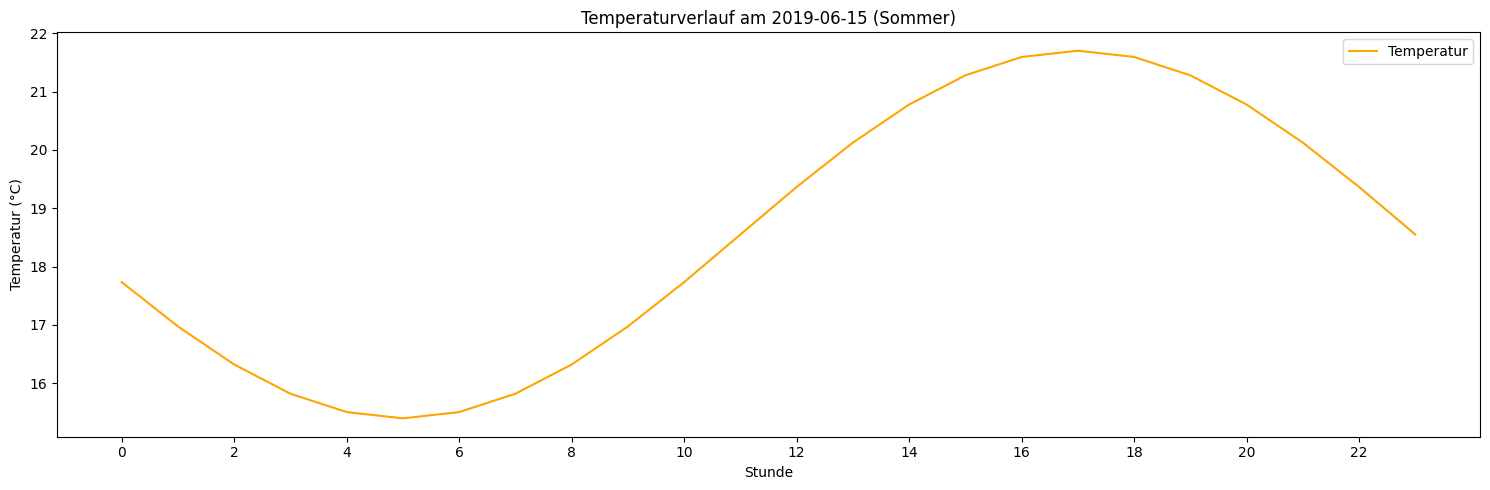

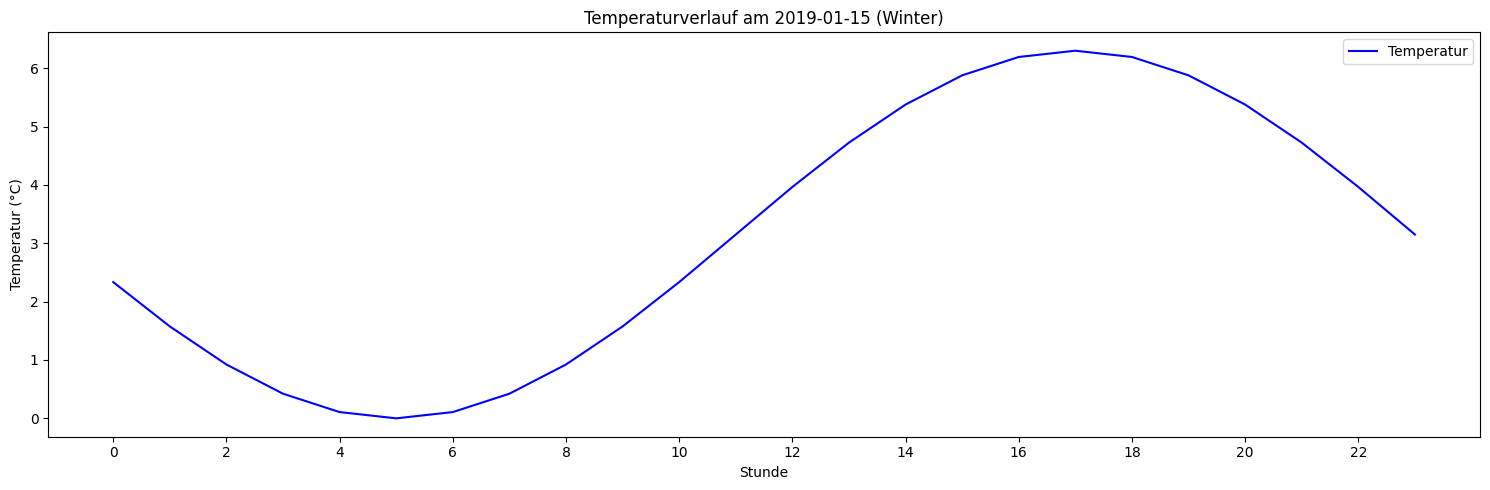

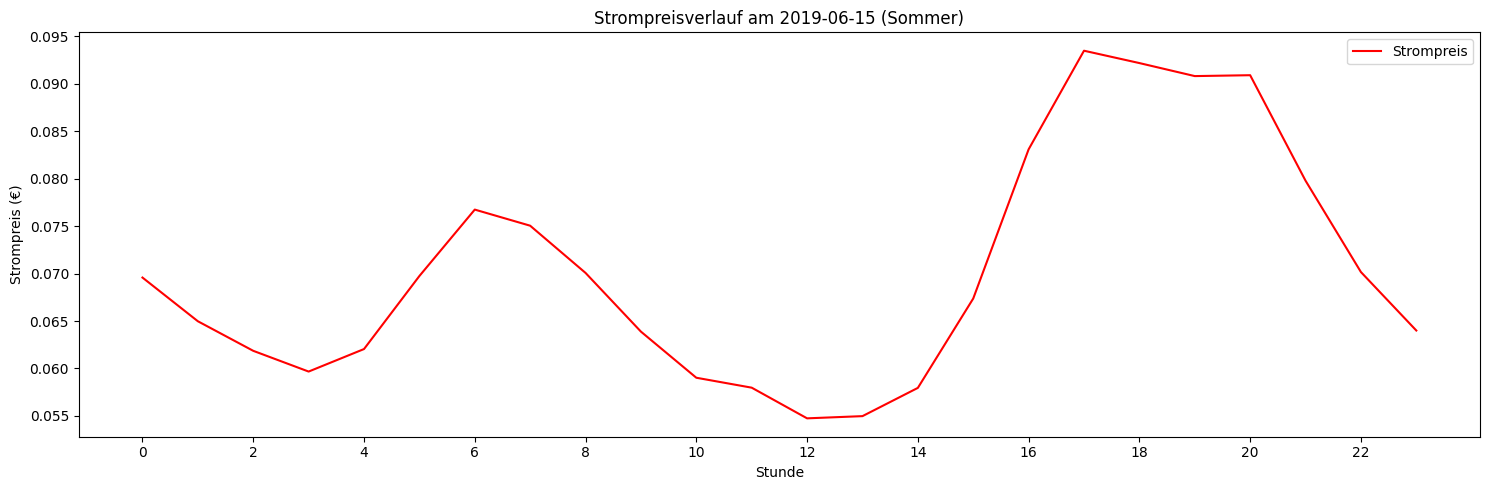

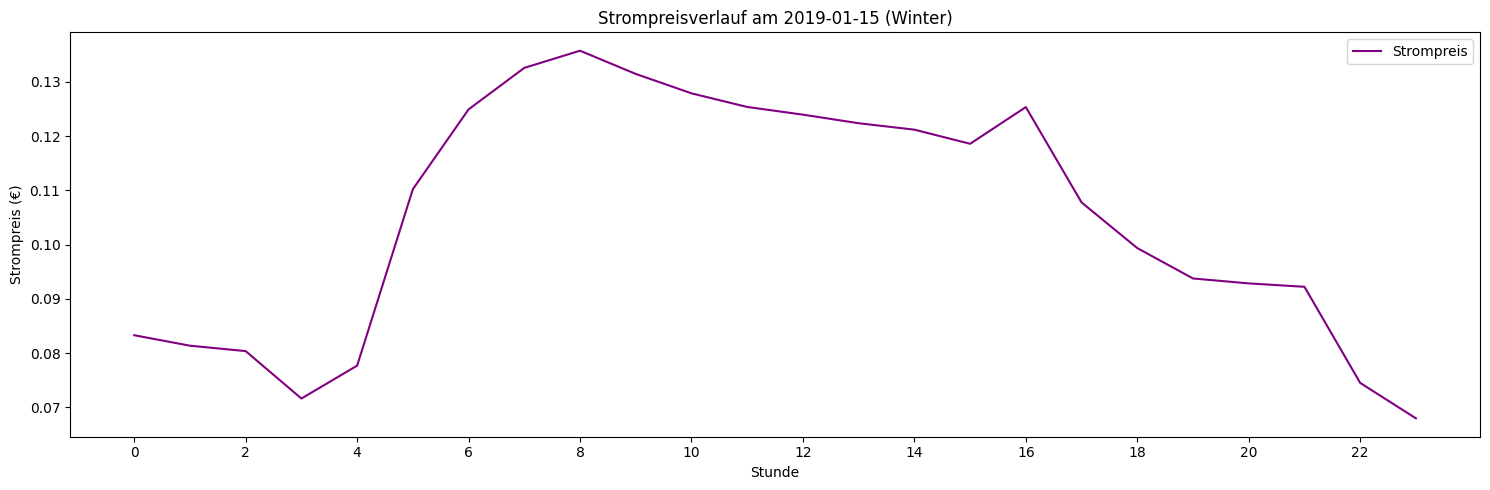

2025-03-27 17:15:52,792 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 17:15:52,808 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


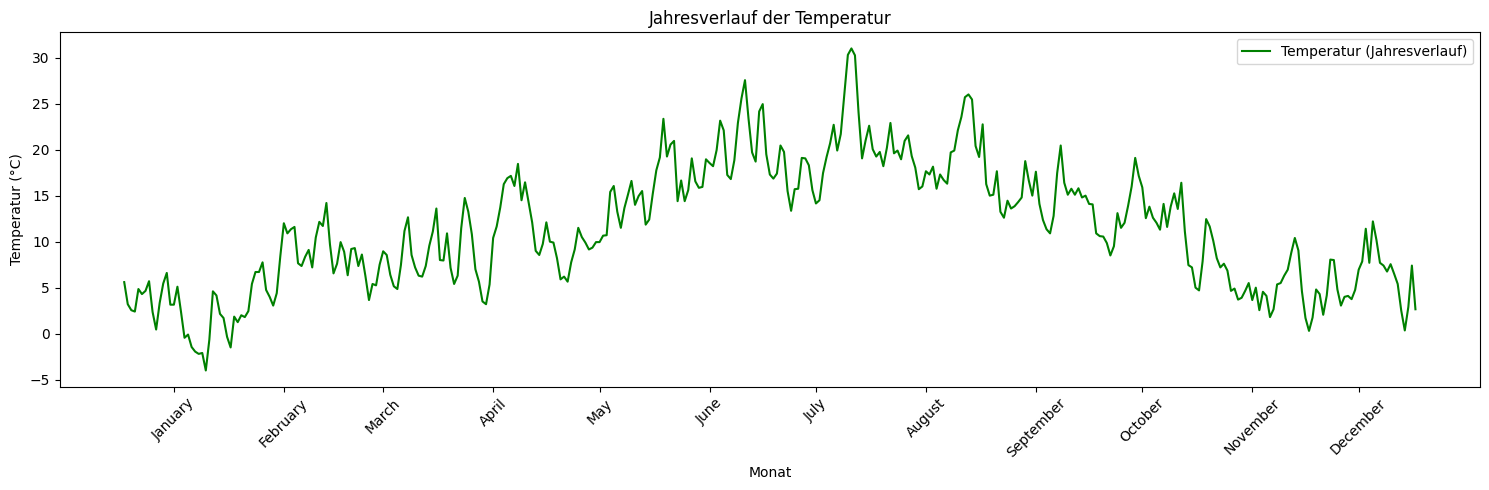

2025-03-27 17:15:52,967 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 17:15:52,982 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


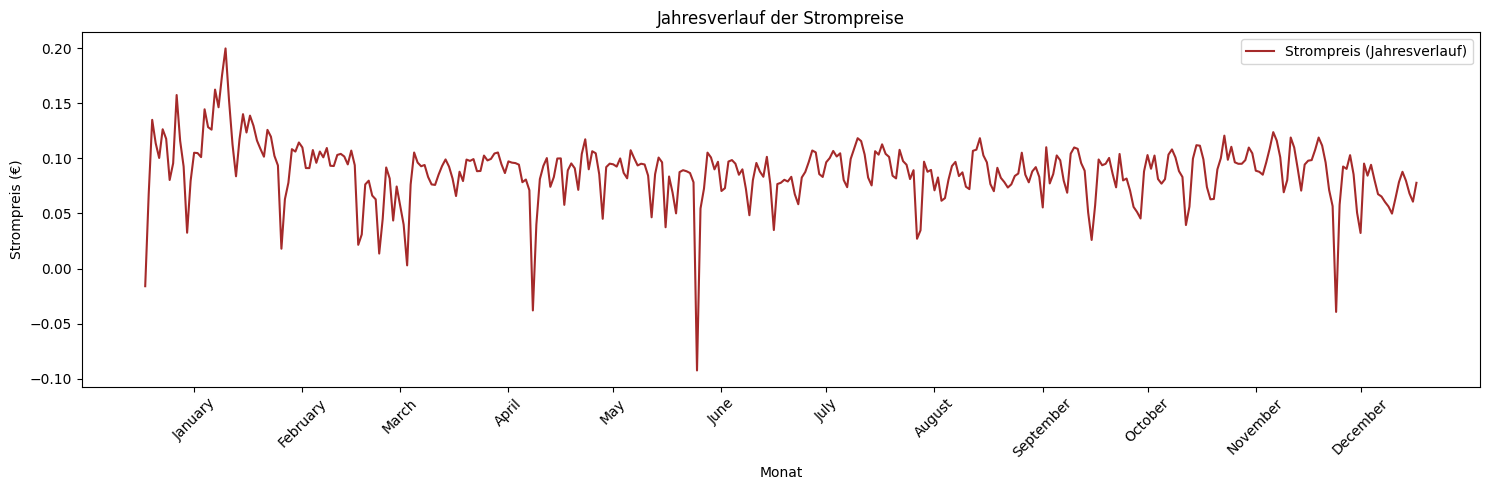

        demand      pv         Zeitstempel  Geschätzte Temperatur  Strompreis  Monat Monatstag
0     0.175220  0.0000 2019-01-01 00:00:00               5.108244    0.023419      1     01-01
1     0.129665  0.0000 2019-01-01 01:00:00               4.650000   -0.009488      1     01-01
2     0.118847  0.0000 2019-01-01 02:00:00               4.256497   -0.023047      1     01-01
3     0.115722  0.0000 2019-01-01 03:00:00               3.954552   -0.017233      1     01-01
4     0.117585  0.0000 2019-01-01 04:00:00               3.764741   -0.029186      1     01-01
5     0.140753  0.0000 2019-01-01 05:00:00               3.700000   -0.040116      1     01-01
6     0.270719  0.0000 2019-01-01 06:00:00               3.764741   -0.035047      1     01-01
7     0.388935  0.0000 2019-01-01 07:00:00               3.954552   -0.011465      1     01-01
8     0.401165  0.0440 2019-01-01 08:00:00               4.256497   -0.014721      1     01-01
9     0.370274  0.2926 2019-01-01 09:00:00        

In [69]:
# Visualisierung der Daten

# Konvertiere die Zeitstempel in pandas DateTime für die Filterung nach Jahreszeit
df_2019['Zeitstempel'] = pd.to_datetime(df_2019['Zeitstempel'])

# Spalte für Monat hinzufügen
df_2019['Monat'] = df_2019['Zeitstempel'].dt.month

# Filter für Sommer- und Wintermonate
sommermonate = [6, 7, 8]
wintermonate = [12, 1, 2]

# Durchschnittlicher Tagesablauf im Sommer und Winter
df_sommer = df_2019[df_2019['Monat'].isin(sommermonate)].copy()
df_winter = df_2019[df_2019['Monat'].isin(wintermonate)].copy()

df_sommer['Stunde'] = df_sommer['Zeitstempel'].dt.hour
df_winter['Stunde'] = df_winter['Zeitstempel'].dt.hour

# Gruppieren nach Stunde und Durchschnitt berechnen
sommer_avg = df_sommer.groupby('Stunde')[['Geschätzte Temperatur', 'Strompreis']].mean()
winter_avg = df_winter.groupby('Stunde')[['Geschätzte Temperatur', 'Strompreis']].mean()

# Konvertiere die Zeitstempel in pandas DateTime für die Filterung nach Datum
df_2019['Zeitstempel'] = pd.to_datetime(df_2019['Zeitstempel'])

# Ein bestimmter Tag im Sommer (z. B. 15. Juli 2019) und Winter (z. B. 15. Januar 2019)
sommer_tag = '2019-06-15'
winter_tag = '2019-01-15'

# Filtern der Daten für den Sommer- und Wintertag
df_sommer_tag = df_2019[df_2019['Zeitstempel'].dt.date == pd.to_datetime(sommer_tag).date()]
df_winter_tag = df_2019[df_2019['Zeitstempel'].dt.date == pd.to_datetime(winter_tag).date()]

# Temperatur-Tagesverlauf (Sommer)
plt.figure(figsize=(15, 5))
plt.plot(df_sommer_tag['Zeitstempel'].dt.hour, df_sommer_tag['Geschätzte Temperatur'], label='Temperatur', color='orange')
plt.title(f'Temperaturverlauf am {sommer_tag} (Sommer)')
plt.xlabel('Stunde')
plt.ylabel('Temperatur (°C)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Temperatur-Tagesverlauf (Winter)
plt.figure(figsize=(15, 5))
plt.plot(df_winter_tag['Zeitstempel'].dt.hour, df_winter_tag['Geschätzte Temperatur'], label='Temperatur', color='blue')
plt.title(f'Temperaturverlauf am {winter_tag} (Winter)')
plt.xlabel('Stunde')
plt.ylabel('Temperatur (°C)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Strompreis-Tagesverlauf (Sommer)
plt.figure(figsize=(15, 5))
plt.plot(df_sommer_tag['Zeitstempel'].dt.hour, df_sommer_tag['Strompreis'], label='Strompreis', color='red')
plt.title(f'Strompreisverlauf am {sommer_tag} (Sommer)')
plt.xlabel('Stunde')
plt.ylabel('Strompreis (€)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Strompreis-Tagesverlauf (Winter)
plt.figure(figsize=(15, 5))
plt.plot(df_winter_tag['Zeitstempel'].dt.hour, df_winter_tag['Strompreis'], label='Strompreis', color='purple')
plt.title(f'Strompreisverlauf am {winter_tag} (Winter)')
plt.xlabel('Stunde')
plt.ylabel('Strompreis (€)')
plt.xticks(range(0, 24, 2))  # Zeige jede zweite Stunde an
plt.legend()
plt.tight_layout()
plt.show()

# Visualisierung des Jahresverlaufs
df_2019['Monatstag'] = df_2019['Zeitstempel'].dt.strftime('%m-%d')
jahresverlauf = df_2019.groupby('Monatstag')[['Geschätzte Temperatur', 'Strompreis']].mean()

# Erstelle eine Liste mit Positionen und Labels für jeden Monat
monat_labels = [f"{month:02d}-15" for month in range(1, 13)]  # Mitte jedes Monats
monat_positionen = [jahresverlauf.index.get_loc(label) for label in monat_labels if label in jahresverlauf.index]

# Temperatur-Diagramm
plt.figure(figsize=(15, 5))
plt.plot(jahresverlauf.index, jahresverlauf['Geschätzte Temperatur'], label='Temperatur (Jahresverlauf)', color='green')
plt.title('Jahresverlauf der Temperatur')
plt.xlabel('Monat')
plt.ylabel('Temperatur (°C)')
plt.xticks(ticks=monat_positionen, labels=[calendar.month_name[int(label.split('-')[0])] for label in monat_labels], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Strompreis-Diagramm
plt.figure(figsize=(15, 5))
plt.plot(jahresverlauf.index, jahresverlauf['Strompreis'], label='Strompreis (Jahresverlauf)', color='brown')
plt.title('Jahresverlauf der Strompreise')
plt.xlabel('Monat')
plt.ylabel('Strompreis (€)')
plt.xticks(ticks=monat_positionen, labels=[calendar.month_name[int(label.split('-')[0])] for label in monat_labels], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
print(df_2019.to_string())

# Wärmepumpe & Pufferspeicher Modell

## Rechnungen zur Vorbereitung der Daten für das Wärmepumpemodell

---

## Berechnung der Heizlast


### 1. Temperaturunterschied

Die Temperaturdifferenz zwischen Innen- und Außentemperatur berechnet sich wie folgt:

$$
\Delta T = T_{\text{innen}} - T_{\text{außen}}
$$

---

### 2. Negative Werte durch 0 ersetzen

Falls die berechnete Temperaturdifferenz negativ ist, wird sie auf 0 gesetzt:

$$
\Delta T = \max(\Delta T, 0)
$$

---

### 3. Transmissionswärmeverluste

Für die Transmissionswärmeverluste durch Wand und Fenster sowie die Summe daraus gelten:

$$
Q_{T,\text{Wand}} = U_{\text{Wand}} \cdot A_{\text{Wand}} \cdot \Delta T
$$

$$
Q_{T,\text{Fenster}} = U_{\text{Fenster}} \cdot A_{\text{Fenster}} \cdot \Delta T
$$

$$
Q_T = Q_{T,\text{Wand}} + Q_{T,\text{Fenster}}
$$

---

### 4. Lüftungswärmeverluste

Der Luftvolumenstrom wird durch Raumvolumen, Luftwechselrate und Zeiteinheit berechnet:

$$
\dot{V} = \frac{V_{\text{Raum}} \cdot \text{Luftwechselrate}}{3600} \quad (\text{m}^3/\text{s})
$$

Daraus ergibt sich für die Lüftungswärmeverluste:

$$
Q_L = \frac{\dot{V} \cdot \rho \cdot c \cdot \Delta T}{1000} \quad (\text{kW})
$$

---

### 5. Gesamte Heizlast

Die gesamte Heizlast pro Zeiteinheit (in kW) setzt sich zusammen aus den Transmissionswärmeverlusten (umgerechnet in kW) und den Lüftungswärmeverlusten:

$$
Q_{\text{ges}} = \frac{Q_T}{1000} + Q_L \quad (\text{kW})
$$

---

## Berechnung der Heizkosten pro kW Wärme

### 1. Vorlauftemperatur berechnen

Die Vorlauftemperatur wird für jede Außentemperatur wie folgt berechnet:

$$
T_{\text{heating}} = a \cdot \bigl(T_{\text{innen}} - T_{\text{außen}}\bigr) + b
$$

---

### 2. Umrechnung in Kelvin

Zur Weiterverarbeitung werden die Vorlauf- und die Außentemperatur in Kelvin umgerechnet:

$$
T_{\text{heating,K}} = T_{\text{heating}} + 273{.}15
$$

$$
T_{\text{source,K}} = T_{\text{außen}} + 273{.}15
$$

---

### 3. COP berechnen

Die Berechnung des Coefficient of Performance (COP) der Wärmepumpe erfolgt mit einer Sicherheitsprüfung:

$$
\text{COP} =
\begin{cases}
\min\!\Bigl(\dfrac{T_{\text{heating,K}}}{T_{\text{heating,K}} - T_{\text{source,K}}} \cdot \text{cop-factor}\; ; \; 6\Bigr),
& \text{falls } T_{\text{heating,K}} > T_{\text{source,K}}, \\[6pt]
6,
& \text{sonst}.
\end{cases}
$$

---

### 4. Heizkosten pro kW Wärme

Die Heizkosten (EUR/kW) für jede Stunde berechnen sich aus dem Strompreis geteilt durch den jeweiligen COP:

$$
c = \frac{\text{Strompreis}}{\text{COP}}
$$



In [70]:
# Außentemperaturen (°C) für jede Stunde
T_aussen = df_2019['Geschätzte Temperatur'].values

# Strompreise
Strompreise = df_2019['Strompreis'].values

# Elektrische Nachfrage des Haushalts ohne Wärmepumpe (kW) für jede Stunde
D_Haushalt = df_2019['demand'].values

# Berechnung der PV-Erzeugung (kW)
PV = df_2019['pv'].values

# Zeitraumlänge in Stunden
T = int(len(df_2019['Strompreis']))

# Temperaturunterschied
delta_T = temp_innen - T_aussen # Temperaturdifferenz innen/außen (K)

# Negative Werte durch 0 ersetzen
delta_T = np.maximum(delta_T, 0)

# Transmissionswärmeverluste
Q_T_wand = U_wand * A_wand * delta_T
Q_T_fenster = U_fenster * A_fenster * delta_T
Q_T = Q_T_wand + Q_T_fenster

# Lüftungswärmeverluste
V_dot = V_raum * luftwechselrate / 3600  # Luftvolumenstrom (m³/s)
Q_L = V_dot * rho * c * delta_T / 1000  # in kW

# Gesamte Heizlast in kW pro Zeiteinheit
Q_ges = Q_T / 1000 + Q_L  # in kW

# Vorlauftemperatur berechnen
T_heating = [a * (temp_innen - temp) + b for temp in T_aussen]

# Umrechnung Vorlauftemperatur & Außentemperatur in Kelvin
T_heating_K = np.array(T_heating) + 273.15
T_source_K = np.array(T_aussen) + 273.15

# COP berechnen mit Sicherheitsprüfung gegen Nulldivision & Obergrenze für COP (da bei Division durch sehr kleiner Werte der COP praxisferne Werte annimmt)
COP = []
for heating, source in zip(T_heating_K, T_source_K):
    if heating > source:
        cop = heating / (heating - source) * cop_vorfaktor
        if cop < 6:
            COP.append(cop)
        else:
            cop = 6
            COP.append(cop)
    else:
        cop = 6
        COP.append(cop)

# Heizkosten pro kW Wärme (EUR/kW) für jede Stunde
c_t = [strompreis / cop for strompreis, cop in zip(Strompreise, COP)]

## Einfluss von Strompreis & COP auf Kosten pro kW Wärme
- Strompreis nimmt positiven Einfluss auf die Kosten pro kW Wärme
- COP nimmt inversen Einfluss auf Kosten pro kW Wärme, da mit steigendem COP die Wärmepumpe effizienter arbeitet

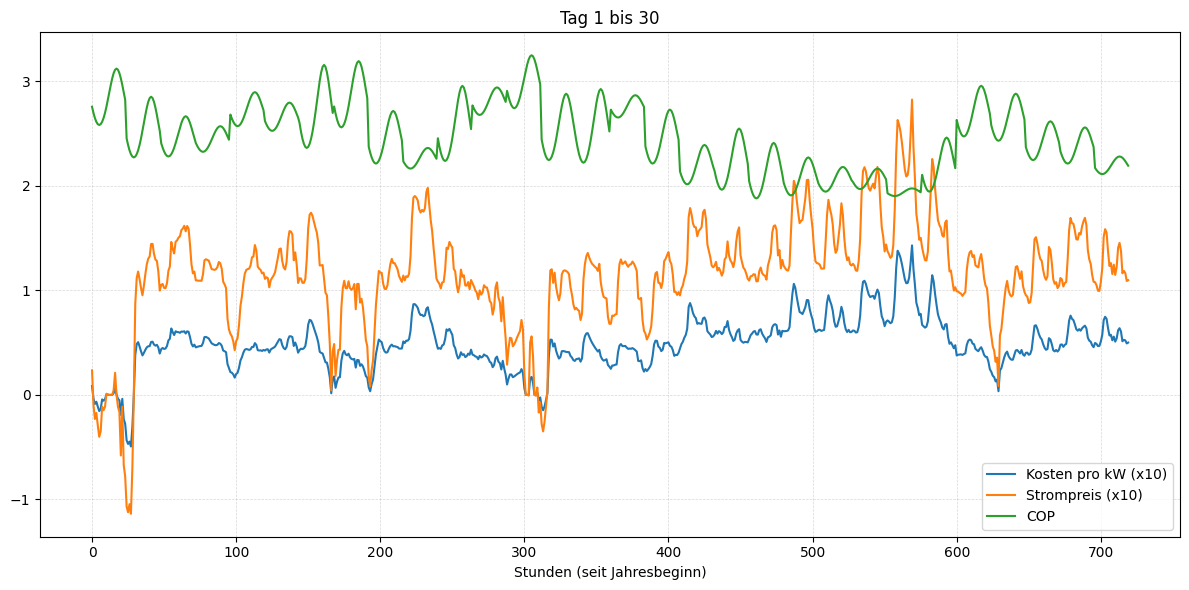

In [71]:
# Datenvorbereitung
df_2019["COP"] = COP
df_2019["Kosten pro kW Wärme"] = c_t
df_2019["Kosten pro kW (x10)"] = df_2019["Kosten pro kW Wärme"] * 10
df_2019["Strompreis (x10)"] = df_2019["Strompreis"] * 10
df_2019["Fixer Strompreis"] = c_pur

# Input gewünschter Zeitraum
day = 1
days = 30

if days == 1: day_safe = f"Tag {day}"
else: day_safe = f"Tag {day} bis {day + days - 1}"

figure, (ax1) = plt.subplots(1, figsize=(12, 6))
df_2019[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["Kosten pro kW (x10)", "Strompreis (x10)", "COP"]].plot(ax=ax1)
labels = ["Kosten pro kWh (x10)", "Strompreis in Euro (x10)", "Leistungszahl (COP)"]
ax1.set_xlabel("Stunden (seit Jahresbeginn)")
ax1.set_title(day_safe)
ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

plt.tight_layout()
plt.show()

# Aufstellung des Optimierungsproblems

## Variablen

- Wärmepumpenleistung $P_t$
- Speicherfüllstand $S_t$
- Ladeleistung des Pufferspeichers $x^{\text{in}}_t$
- Entladeleistung des Pufferspeichers $x^{\text{out}}_t$

---

## Parameter

- Kosten pro kW Wärme $c_{\text{t}}$
- Gesamter Wärmebedarf $Q^{\text{ges}}_t$
- Verlustfaktor des Pufferspeichers $\text{loss}_{\text{puf}}$
- Wirkungsgrad der Speicherladung $\eta_{\text{puf}}$
- Anfangsfüllstand des Pufferspeichers $S_{\text{start}}$

---

## Zielfunktion

- Minimierung der Gesamtkosten:
  $$ \min \sum_{t=1}^{T} c_t \cdot P_t $$

---

## Nebenbedingungen

- Deckung des Wärmebedarfs:
  $$ Q^{\text{ges}}_t = P_t + x^{\text{out}}_t - x^{\text{in}}_t $$

- Dynamik des Speicherfüllstands:
  $$ S_{t+1} = (1 - \text{loss}_{\text{puf}}) \cdot S_t + \eta_{\text{puf}} \cdot x^{\text{in}}_t - x^{\text{out}}_t $$

- Anfangsfüllstand des Pufferspeichers:
  $$ S_0 = S_{\text{start}} + x^{\text{in}}_0 - x^{\text{out}}_0 $$

- Begrenzungen von Wärmepumpe-Leistung, Pufferspeicherkapazität, Lade- & Entladeleistung des Pufferspeichers:
  $$ 0 \leq P_t \leq P_{\text{max}} $$
  $$ 0 \leq S_t \leq S_{\text{max}} $$
  $$ 0 \leq x^{\text{in}}_t \leq S_{\text{laden}} $$
  $$ 0 \leq x^{\text{out}}_t \leq S_{\text{entladen}} $$




In [72]:
# Variablen und deren Begrenzungen

# Wärmepumpe-Leistung
P = [p.LpVariable(f"p_{t}", lowBound=0, upBound=p_max) for t in range(T)]
# Pufferspeicher-Kapazität
S = [p.LpVariable(f"B_{t}", lowBound=0, upBound=s_max) for t in range(T)]
# Ladung Pufferspeicher
x_in = [p.LpVariable(f"x_in_{t}", lowBound=0, upBound=s_laden) for t in range(T)]
# Entnahme Pufferspeicher
x_out = [p.LpVariable(f"x_out_{t}", lowBound=0, upBound=s_entladen) for t in range(T)]

In [73]:
# Weitere Nebenbedingungen
constraints = []

# Deckung des Wärmebedarfs
for t in range(T):
    constraints.append(Q_ges[t] == P[t] + x_out[t] - x_in[t])

# Dynamik des Speicherfüllstands
for t in range(T-1):
    constraints.append(S[t+1] == (1 - loss_puf) * S[t] + eta_puf * x_in[t] - x_out[t])

# Anfangsfüllstand des Wärmespeichers
constraints.append(S[0] == S_start + x_in[0] - x_out[0])

In [74]:
# Zielfunktion
objective = p.lpSum([c_t[t] * P[t] for t in range(T)])

In [75]:
# Erstelle das Optimierungsproblem
model_1 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_1 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_1 += constraint

# Löse das Problem
model_1.solve()

# Status des Modells abfragen
status = p.LpStatus[model_1.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model_1.status])
    print(f"Kosten:", round(p.value(model_1.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfen Sie ihre Eingaben!")

Status: Optimal
Kosten: 247.2 €


## Visualisierung der Interaktion von Wärmepumpe und Pufferspeicher
- Wärmepumpen-Leistung nimmt zu wenn Wärme in den Pufferspeicher eingespeist wird
- Wärmepumpen-Leistung sinkt wenn Wärme aus dem Pufferspeicher entnommen wird

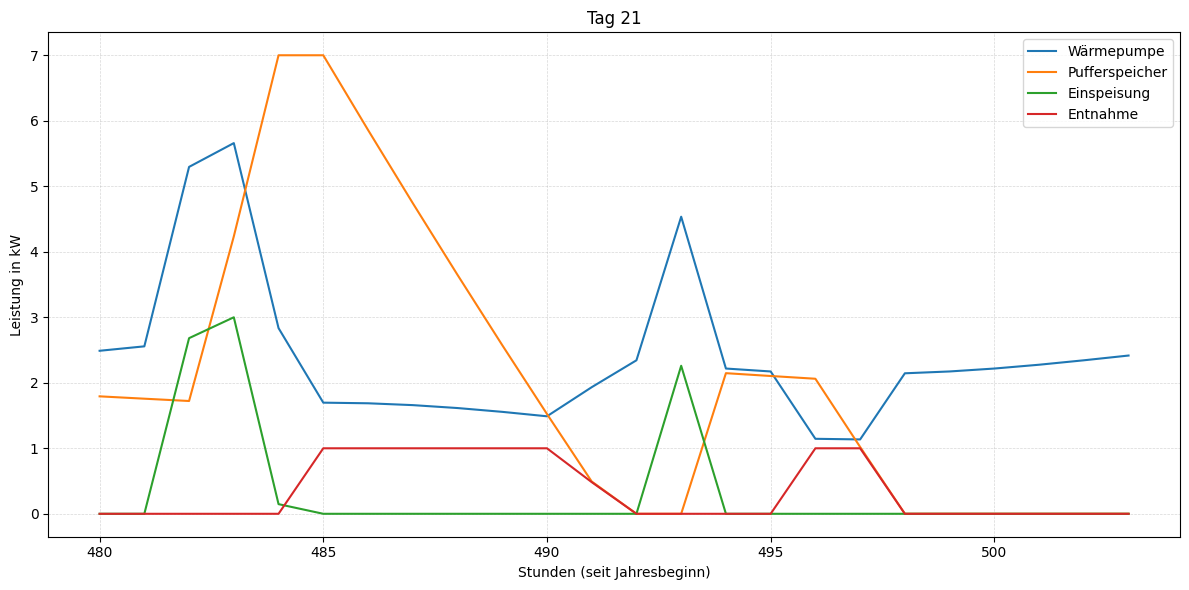

In [76]:
# Dataframe erstellen
data = {
    'Zeit': list(range(T)),
    'Wärmepumpe': [P[t].varValue for t in range(T)],
    'Pufferspeicher': [S[t].varValue for t in range(T)],
    'Einspeisung': [x_in[t].varValue for t in range(T)],
    'Entnahme': [x_out[t].varValue for t in range(T)],
}

df_pump = pd.DataFrame(data)

# Input gewünschter Zeitraum
day = 21
days = 1

if days == 1: day_safe = f"Tag {day}"
else: day_safe = f"Tag {day} bis {day + days - 1}"

figure, (ax1) = plt.subplots(1, figsize=(12, 6))
df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["Wärmepumpe", "Pufferspeicher"]].plot(ax=ax1)
df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["Einspeisung", "Entnahme"]].plot(ax=ax1)
#df_pump[(day - 1) * 24:((day - 1) * 24) + days * 24 ][["Einspeisung", "Entnahme"]].plot(ax=ax1, drawstyle='steps-post')
ax1.set_ylabel("Leistung in kW")
ax1.set_xlabel("Stunden (seit Jahresbeginn)")
ax1.set_title(day_safe)
ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

plt.tight_layout()
plt.show()

## Bestimmung der Amortisationsdauer

- Amortisationsdauer gibt die Dauer an, bis die Anschaffungskosten durch Ersparnisse geckeckt werden

$$
T_{\text{Amortisation}} = \frac{\text{Anschaffungskosten}}{\text{Jährliche Ersparnis}}
$$



In [77]:
#Amortisationsdauer von Wärmepumpe + Pufferspeicher, ohne Basismodellerweiterung
cost = p.value(model_1.objective)
buy_cost = buy_pump + buy_storage

print("Anschaffungskosten W & P: ", buy_cost, "€")
print("Heizkosten ohne W & P: ", round(heating_bill, 2), "€")
print("Heizkosten mit W & P : ", round(cost, 2), "€")
print("Einsparung Kosten durch W & P : ", round(heating_bill - cost, 2), "€")
print("Einsparungen Kosten in Prozent: ", round(((heating_bill - cost) / heating_bill ) * 100, 2), "%")
print("Amortisationsdauer in Jahren: ", round(buy_cost / (heating_bill - cost), 2), "Jahre")


Anschaffungskosten W & P:  13800 €
Heizkosten ohne W & P:  1730 €
Heizkosten mit W & P :  247.2 €
Einsparung Kosten durch W & P :  1482.8 €
Einsparungen Kosten in Prozent:  85.71 %
Amortisationsdauer in Jahren:  9.31 Jahre


## Basismodell
Bewertung von Photovoltaik-Anlagen zur Deckung des Eigenbedarfs inkl. Batteriespeicher

Text(0.5, 1.0, 'Woche 23')

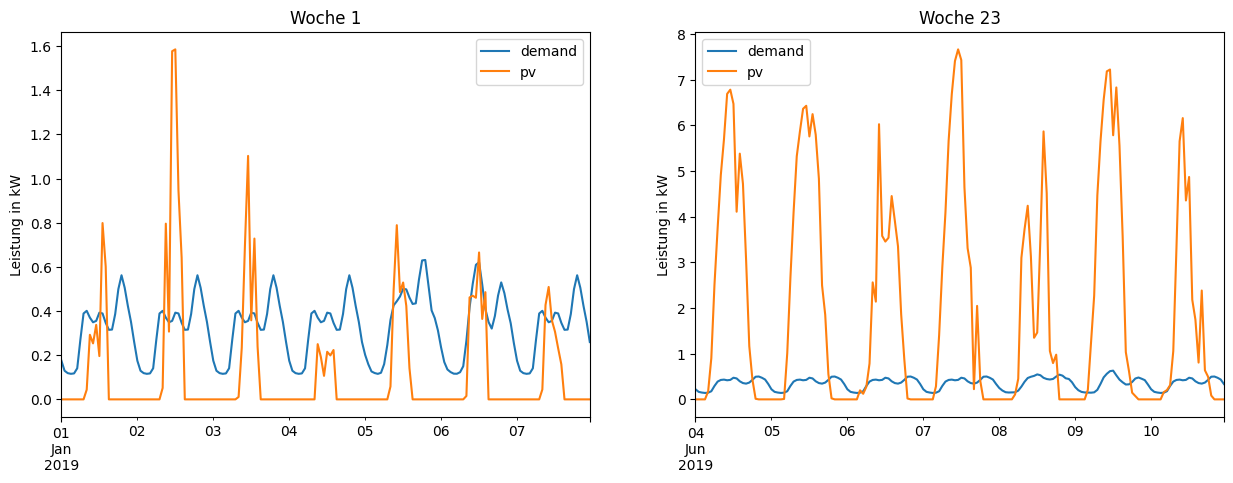

In [78]:
# Plotte das Lastprofil und das Erzeugungsprofil für zwei ausgewählte Wochen in subplots nebeneinander
week_no_left = 1
week_no_right = 23

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
energiesystem[(week_no_left-1)*24*7:week_no_left*24*7].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title("Woche " + str(week_no_left))

energiesystem[(week_no_right-1)*24*7:week_no_right*24*7].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_title("Woche " + str(week_no_right))

## Eigenverbrauchsquote & Autarkiegrad

- die Eigenverbrauchsquote besagt wie viel Prozent der gesamt erzeugten PV-Leistung selbst genutzt wird
- die Autarkiequote gibt an wie viel Prozent des eigenen Energiebedarfs durch PV-Leistung gedeckt wird

$$
\text{Eigenverbrauchsquote} = \left( \frac{E_{\text{Eigenverbrauch}}}{E_{\text{Erzeugung}}} \right) \times 100\%
$$

$$
\text{Autarkiegrad} = \left( \frac{E_{\text{Eigenverbrauch}}}{E_{\text{Gesamtbedarf}}} \right) \times 100\%
$$

In [79]:
# Berechne den Eigenverbrauch
energiesystem["feedin"] = energiesystem["pv"] - energiesystem["demand"]
energiesystem["feedin"] = energiesystem["feedin"].clip(lower=0)

energiesystem["self_consumption"] = energiesystem["pv"] - energiesystem["feedin"]

energiesystem["electricity_purchase"] = energiesystem["demand"] - energiesystem["self_consumption"]

energiesystem.index.name = 't'

# Gib die Eigenverbrauchsquote aus
eigenverbrauchsquote = energiesystem["self_consumption"].sum() / energiesystem["pv"].sum() * 100
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0f} %")

# Gib die Autarkiequote aus
autarkiegrad = energiesystem["self_consumption"].sum() / energiesystem["demand"].sum() * 100
print(f"Autarkiegrad: {autarkiegrad:.0f} %")

Eigenverbrauchsquote: 16 %
Autarkiegrad: 49 %


# Aufstellung eines Optimierungsproblems

## Zielfunktion
- Minimierung der Kosten abzüglich der Einspeisevergütung
- Strombezug aus dem Netz $y^{pur}_t$
- Einspeisung in das Netz $y^{pv,feedin}_t$
- Einspeisevergütung $c^{feedin}$
- Bezugskosten $c^{pur}$
$$ \min \sum_{t=1}^{T} (y^{pur}_t \cdot c^{pur} \cdot {dt} - y^{pv,feedin}_t \cdot c^{feedin} \cdot {dt}) $$

## Nebenbedingungen
- Deckung der Nachfrage $D_t$ aus Netzbezug $y^{pur}_t$, PV Eigennutzung, $y^{pv,self}_t$ und Entladung Batterie $y^{s,dc}_t$
$$ y^{pur}_t + y^{pv,self}_t + y^{s,dc}_t - y^{s,ch}_t = D_t $$
- Aufteilung der gesamten PV-Erzeugung ${PV}_t$ in Eigennutzung $y^{pv,self}_t$ und Einspeisung $y^{pv,feedin}_t$
$$ y^{pv,self}_t + y^{pv,feedin}_t = {PV}_t $$

- Speicherfüllstandsrestriktionen (Speicherfüllstand $l^s_t$) mit Batteriekapazität $E^{bat}$, Lade-/Entladeleistung $P^{bat}$ und Wirkungsgrad $\eta_{bat}$
$$ y^{s,dc}_t <= P^{bat} $$
$$ y^{s,ch}_t <= P^{bat} $$
$$ l^s_t + y^{s,ch}_t \cdot \eta_{bat} \cdot {dt} - y^{s,dc}_t \cdot {dt} - l^s_{t+1}= 0 $$
$$ 0 <= l^s_t <= E^{bat} $$

---

## Optimierungsproblem in Pulp für Kompatibilität

In [80]:
 # Variablen & Nebenbedingungen

y_pur = [p.LpVariable(f"y_pur_{t}", lowBound=0) for t in range(T)]
# PV-Eigennutzung
y_pv_self = [p.LpVariable(f"y_pv_self_{t}", lowBound=0) for t in range(T)]
# PV-Verkauf
y_pv_feedin = [p.LpVariable(f"y_pv_feedin_{t}", lowBound=0) for t in range(T)]
# Batterie-Ladung
y_s_ch = [p.LpVariable(f"y_s_ch_{t}", lowBound=0, upBound=P_bat) for t in range(T)]
# Batterie-Entladung
y_s_dc = [p.LpVariable(f"y_s_dc_{t}", lowBound=0, upBound=P_bat) for t in range(T)]
# Batteriefüllstand
l_s = [p.LpVariable(f"l_s_{t}", lowBound=0, upBound=E_bat) for t in range(T)]

In [81]:
# Liste für aller sonstigen Nebenbedingungen
constraints = []

for t in range(T):
    # Aufteilung der PV-Erzeugung
    constraints.append(y_pv_self[t] + y_pv_feedin[t] == PV[t])
    # Deckung der elektrischen Nachfrage
    constraints.append(y_pur[t] + y_pv_self[t] + y_s_dc[t] - y_s_ch[t] == D_Haushalt[t])

for t in range(T-1):
    # Dynamik des Batterie-Füllstands
    constraints.append(l_s[t+1] == l_s[t] + y_s_ch[t] * eta_bat - y_s_dc[t])

In [82]:
# Zielfunktion
cost_grid = p.lpSum([y_pur[t] * c_pur for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin for t in range(T)])

objective = p.lpSum([y_pur[t] * c_pur - y_pv_feedin[t] * c_feedin for t in range(T)])

In [83]:
# Erstelle das Optimierungsproblem
model_2 = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model_2 += objective

# Füge alle Nebenbedingungen hinzu
for constraint in constraints:
    model_2 += constraint

# Löse das Problem
model_2.solve()

# Status des Modells abfragen
status = p.LpStatus[model_2.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model_2.status])
    print(f"Kosten:", round(p.value(model_2.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfen Sie ihre Eingaben!")

Status: Optimal
Kosten: -69.86 €


## Darstellung des Stromflusses

- Die Grafik beschreibt wie der Strombedarf optimal im zeitlichen Verlauf durch PV-Bezug, Stromtarif-Bezug oder durch Batterieentnahme gedeckt wird
- Der Verlauf zeigt außerdem die Zeitpunke an denen PV-Strom verkauft wird

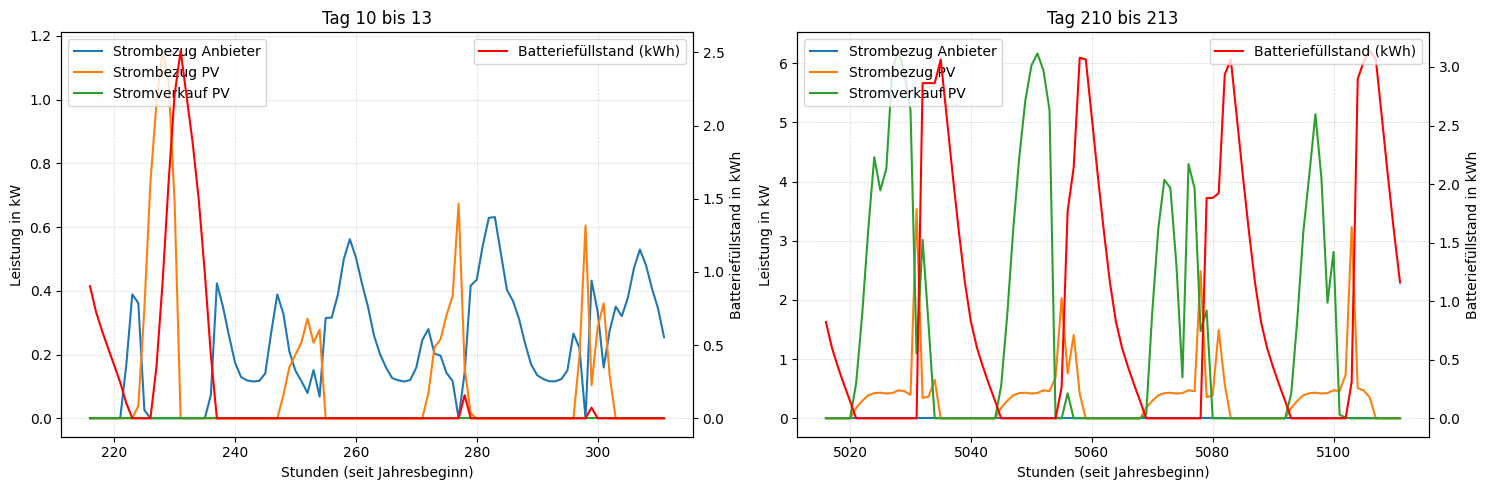

In [26]:
# Datenvorbereitung
data = {
    'Zeit': list(range(T)),
    'Strombezug Anbieter': [y_pur[t].varValue for t in range(T)],
    'Strombezug PV': [y_pv_self[t].varValue for t in range(T)],
    'Stromverkauf PV': [y_pv_feedin[t].varValue for t in range(T)],
    'Laden Batterie': [y_s_ch[t].varValue for t in range(T)],
    'Entladen Batterie': [y_s_dc[t].varValue for t in range(T)],
    'Batteriefüllstand': [l_s[t].varValue for t in range(T)],
    'PV-Erzeugnis': [PV[t] for t in range(T)],
}

df_basis = pd.DataFrame(data)

# Input gewünschter Zeitraum
day_left = 10
day_right = 210
days = 4

if days == 1: day_safe = f"Tag {day_left}"
else: day_safe = f"Tag {day_left} bis {day_left + days - 1}"

if days == 1: day_safe_1 = f"Tag {day_right}"
else: day_safe_1 = f"Tag {day_right} bis {day_right + days - 1}"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ==== LINKER PLOT ====
df_left = df_basis[(day_left - 1) * 24:((day_left - 1) * 24) + days * 24]

# Hauptachsen: Stromdaten
df_left[["Strombezug Anbieter", "Strombezug PV", "Stromverkauf PV"]].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_xlabel("Stunden (seit Jahresbeginn)")
ax1.set_title(day_safe)
ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

# Zweite Y-Achse für Batteriefüllstand (rot)
ax1b = ax1.twinx()
df_left["Batteriefüllstand"].plot(ax=ax1b, color="red", label="Batteriefüllstand (kWh)")
ax1b.set_ylabel("Batteriefüllstand in kWh")

# Legenden getrennt
ax1.legend(loc="upper left")
ax1b.legend(loc="upper right")

# ==== RECHTER PLOT ====
df_right = df_basis[(day_right - 1) * 24:((day_right - 1) * 24) + days * 24]

# Hauptachsen: Stromdaten
df_right[["Strombezug Anbieter", "Strombezug PV", "Stromverkauf PV"]].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_xlabel("Stunden (seit Jahresbeginn)")
ax2.set_title(day_safe_1)
ax2.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

# Zweite Y-Achse für Batteriefüllstand (rot)
ax2b = ax2.twinx()
df_right["Batteriefüllstand"].plot(ax=ax2b, color="red", label="Batteriefüllstand (kWh)")
ax2b.set_ylabel("Batteriefüllstand in kWh")

# Legenden getrennt
ax2.legend(loc="upper left")
ax2b.legend(loc="upper right")

plt.tight_layout()
plt.show()



## Gesamtkosten bei Nutzung beider Systeme ohne Systemintegration
- Summe der Kosten aus Wärmepumpe- und Basismodell

In [27]:
# Berechnung Gesamtkosten
print(f"Kosten Wärmepumpe-Modell :", round(p.value(model_1.objective), 2), "€")
print(f"Kosten Basismodell :", round(p.value(model_2.objective), 2), "€")
cost_sum = round(p.value(model_1.objective) + p.value(model_2.objective), 2)
print(f"Gesamtkosten: ", cost_sum, "€")

Kosten Wärmepumpe-Modell : 247.2 €
Kosten Basismodell : -69.86 €
Gesamtkosten:  177.34 €


# Fusion beider Modelle

## Variablen

- Wärmepumpenleistung $P_t$
- Thermischer Speicherfüllstand $S_t$
- Ladeleistung des Pufferspeichers $x^{\text{in}}_t$
- Entladeleistung des Pufferspeichers $x^{\text{out}}_t$
- Strombezug aus dem Netz $y^{\text{pur}}_t$
- PV-Strom, der direkt genutzt wird $y^{\text{pv\_self}}_t$
- PV-Einspeisung ins Netz $y^{\text{pv\_feedin}}_t$
- Batterieladeleistung $y^{\text{s\_ch}}_t$
- Batterieentladeleistung $y^{\text{s\_dc}}_t$
- Batteriefüllstand $l^s_t$
- WP-Strombezug durch Batterie $y^{\text{heat\_bat}}_t$
- WP-Strombezug durch PV $y^{\text{heat\_pv}}_t$
- WP-Strombezug durch Netz $y^{\text{heat\_pur}}_t$
- Haushaltsstrombezug durch Batterie $y^{\text{s\_dc\_home}}_t$
- PV-Strom für den Haushalt $y^{\text{pv\_self\_home}}_t$
---

## Parameter

- Strompreis für Netzbezug $c^{\text{pur}}$
- Vergütung für PV-Einspeisung $c^{\text{feedin}}$
- Kostenfaktor (variabler Stromtarif) $c^{\text{var}}_t$
- Gesamtwärmebedarf $Q^{\text{ges}}_t$
- Haushaltsstrombedarf $D^{\text{Haushalt}}_t$
- Verlustfaktor des Pufferspeichers $\text{loss}_{\text{puf}}$
- Wirkungsgrad des Pufferspeichers $\eta_{\text{puf}}$
- Anfangsfüllstand des Pufferspeichers $S_{\text{start}}$
- PV-Erzeugung $\text{PV}_t$
- Wirkungsgrad der Batterie $\eta_{\text{bat}}$
- Technische Grenzen:
  $P_{\text{max}}, \;s_{\text{max}}, \;s_{\text{laden}}, \;s_{\text{entladen}}, \;P_{\text{bat}}, \;E_{\text{bat}}$
  -
---

## Zielfunktion

- **Minimierung der Gesamtkosten**:
$$
\min \sum_{t=1}^{T} \Bigl(
  c^{\text{var}}_t \cdot y^{\text{heat\_pur}}_t
  \;+\;
  c^{\text{pur}} \cdot y^{\text{pur}}_t
  \;-\;
  c^{\text{feedin}} \cdot y^{\text{pv\_feedin}}_t
\Bigr)
$$

---

## Nebenbedingungen

1. **Deckung des Wärmebedarfs**
   $$
   Q^{\text{ges}}_t
   = P_t
   + x^{\text{out}}_t
   - x^{\text{in}}_t
   $$

2. **Deckung des Haushaltsstrombedarfs**
   $$
   y^{\text{pur}}_t
   + y^{\text{pv\_self\_home}}_t
   + y^{\text{s\_dc\_home}}_t
   - y^{\text{s\_ch}}_t
   = D^{\text{Haushalt}}_t
   $$

3. **Dynamik des Speicherfüllstands (thermisch)**
   $$
   S_{t+1}
   = (1 - \text{loss}_{\text{puf}})\, S_t
   + \eta_{\text{puf}} \, x^{\text{in}}_t
   - x^{\text{out}}_t
   $$

4. **Anfangsfüllstand des Wärmespeichers**
   $$
   S_0
   = S_{\text{start}}
   + x^{\text{in}}_0
   - x^{\text{out}}_0
   $$

5. **Aufteilung der PV-Erzeugung**
   $$
   y^{\text{pv\_self}}_t
   + y^{\text{pv\_feedin}}_t
   = \text{PV}_t
   $$

6. **Dynamik des Batteriefüllstands**
   $$
   l^s_{t+1}
   = l^s_t
   + \eta_{\text{bat}} \; y^{\text{s\_ch}}_t
   - y^{\text{s\_dc}}_t
   $$

7. **Batterie-Entladung**
   $$
   y^{\text{s\_dc}}_t
   = y^{\text{heat\_bat}}_t
   + y^{\text{s\_dc\_home}}_t
   $$

8. **Wärmepumpen-Strombedarf**
   $$
   P_t
   = y^{\text{heat\_pur}}_t
   + y^{\text{heat\_bat}}_t
   + y^{\text{heat\_pv}}_t
   $$

9. **Aufteilung des PV-Eigenverbrauchs**
   $$
   y^{\text{pv\_self}}_t
   = y^{\text{pv\_self\_home}}_t
   + y^{\text{heat\_pv}}_t
   $$


10. **Grenzen der Variablen**

$$ 0 \leq P_t \leq P_{\text{max}} $$
$$ 0 \leq S_t \leq s_{\text{max}} $$
$$ 0 \leq x^{\text{in}}_t \leq s_{\text{laden}} $$
$$ 0 \leq x^{\text{out}}_t \leq s_{\text{entladen}} $$
$$ 0 \leq y^{\text{pur}}_t $$
$$ 0 \leq y^{\text{pv\_self}}_t $$
$$ 0 \leq y^{\text{pv\_feedin}}_t $$
$$ 0 \leq y^{\text{s\_ch}}_t \leq P_{\text{bat}} $$
$$ 0 \leq y^{\text{s\_dc}}_t \leq P_{\text{bat}} $$
$$ 0 \leq l^s_t \leq E_{\text{bat}} $$
$$ 0 \leq y^{\text{heat\_bat}}_t $$
$$ 0 \leq y^{\text{heat\_pv}}_t \leq \text{PV}_t $$
$$ 0 \leq y^{\text{heat\_pur}}_t $$
$$ 0 \leq y^{\text{s\_dc\_home}}_t $$
$$ 0 \leq y^{\text{pv\_self\_home}}_t $$



In [28]:
# Variablen und deren Begrenzungen

# Wärmepumpe-Leistung
P = [p.LpVariable(f"p_{t}", lowBound=0, upBound=p_max) for t in range(T)]
# Pufferspeicher-Kapazität
S = [p.LpVariable(f"B_{t}", lowBound=0, upBound=s_max) for t in range(T)]
# Ladung Pufferspeicher
x_in = [p.LpVariable(f"x_in_{t}", lowBound=0, upBound=s_laden) for t in range(T)]
# Entnahme Pufferspeicher
x_out = [p.LpVariable(f"x_out_{t}", lowBound=0, upBound=s_entladen) for t in range(T)]
# Strombezug aus fixem Stromvertrag
y_pur = [p.LpVariable(f"y_pur_{t}", lowBound=0) for t in range(T)]
# PV-Eigennutzung
y_pv_self = [p.LpVariable(f"y_pv_self_{t}", lowBound=0) for t in range(T)]
# PV-Verkauf
y_pv_feedin = [p.LpVariable(f"y_pv_feedin_{t}", lowBound=0) for t in range(T)]
# Batterie-Ladung
y_s_ch = [p.LpVariable(f"y_s_ch_{t}", lowBound=0, upBound=P_bat) for t in range(T)]
# Batterie-Entladung
y_s_dc = [p.LpVariable(f"y_s_dc_{t}", lowBound=0, upBound=P_bat) for t in range(T)]
# Batteriefüllstand
l_s = [p.LpVariable(f"l_s_{t}", lowBound=0, upBound=E_bat) for t in range(T)]
# Wärmepumpenstrombezug durch Batterie
y_heat_bat = [p.LpVariable(f"y_heat_bat_{t}", lowBound=0) for t in range(T)]
# Wärmepumpenstrombezug durch PV-Anlage
y_heat_pv = [p.LpVariable(f"y_heat_pv_{t}", lowBound=0, upBound=PV[t]) for t in range(T)]
# Wärmepumpenstrombezug durch variablen Stromtarif
y_heat_pur = [p.LpVariable(f"y_heat_pur_{t}", lowBound=0) for t in range(T)]
# Haushaltsstrombezug durch Batterie
y_s_dc_home = [p.LpVariable(f"y_s_dc_home_{t}", lowBound=0) for t in range(T)]
# Haushalsstrombezug durch PV
y_pv_self_home = [p.LpVariable(f"y_pv_self_home_{t}", lowBound=0) for t in range(T)]

#Weitere Nebenbedingungen
constraints_final = []

for t in range(T):
    # Deckung des Wärmebedarfs
    constraints_final.append(Q_ges[t] == P[t] + x_out[t] - x_in[t])
    # Deckung Strombedarf Haushalt
    constraints_final.append(y_pur[t] + y_pv_self_home[t] + y_s_dc_home[t] - y_s_ch[t]  == D_Haushalt[t])
    # Aufteilung der PV-Erzeugung
    constraints_final.append(y_pv_self[t] + y_pv_feedin[t] == PV[t])
    # Konstante Deckung der von der Wärmepumpe benötigten Energie
    constraints_final.append(P[t] == y_heat_pur[t] + y_heat_bat[t] + y_heat_pv[t])
    # Aufteilung der Batterie-Entladung durch WP & Haushalt
    constraints_final.append(y_s_dc[t] == y_heat_bat[t] + y_s_dc_home[t])
     # Aufteilung des PV-Eigenverbrauchs auf WP & Haushalt
    constraints_final.append(y_pv_self[t] == y_heat_pv[t] + y_pv_self_home[t])

for t in range(T-1):
    # Dynamik des Speicherfüllstands
    constraints_final.append(S[t+1] == (1 - loss_puf) * S[t] + eta_puf * x_in[t] - x_out[t])
    # Dynamik des Batterie-Füllstands
    constraints_final.append(l_s[t+1] == l_s[t] + y_s_ch[t] * eta_bat - y_s_dc[t])

# Anfangsfüllstand des Wärmespeichers
constraints_final.append(S[0] == S_start + x_in[0] - x_out[0])

# Zielfunktion: Minimierung der Gesamtkosten
cost_grid = p.lpSum([y_pur[t] * c_pur for t in range(T)])
revenue_pv = p.lpSum([y_pv_feedin[t] * c_feedin for t in range(T)])
cost_pump = p.lpSum([c_t[t] * y_heat_pur[t] for t in range(T)])

objective_final = p.lpSum([cost_pump, cost_grid, -revenue_pv])

# Erstelle das Optimierungsproblem
model = p.LpProblem("Energieoptimierung", p.LpMinimize)

# Füge die Zielfunktion hinzu
model += objective_final

# Füge alle Nebenbedingungen hinzu
for constraint in constraints_final:
    model += constraint

# Löse das Problem
model.solve()

1

In [38]:
# Status des Modells abfragen
status = p.LpStatus[model.status]

# Ergebnisse anzeigen
if status == "Optimal":
    print("Status:", p.LpStatus[model.status])
    print(f"Kosten Systemintegration: ", round(p.value(model.objective), 2), "€")
elif status == "Infeasible":
    print("Das Modell ist unlösbar. Es gibt keine Lösung, die alle Nebenbedingungen erfüllt. Bitte überprüfen Sie ihre Eingaben!")

Status: Optimal
Kosten Systemintegration:  161.76 €


## Übersicht Struktur & Größe des Modells

- Der Solver löst eine Matrix folgender Form:

\
\begin{aligned}
A_{MxN} &=
  \begin{pmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} & \cdots & a_{1,N} \\
    a_{2,1} & a_{2,2} & a_{2,3} & \cdots & a_{2,N} \\
    a_{3,1} & a_{3,2} & a_{3,3} & \cdots & a_{3,N} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    a_{M,1} & a_{M,2} & a_{M,3} & \cdots & a_{M,N} \\
  \end{pmatrix}
\end{aligned}

In [30]:
# Mini-Exkurs Lineare Algebra
print("Modelldimensionen: " + str(len(model.constraints)) + " x "+ str(len(model.variables())))
print(("-")*70)
print("Zeilen repräsentieren Anzahl der Nebenbedingungen (M):", len(model.constraints))
print("Spalten repräsentieren Anzahl der Entscheidungsvariablen (N):", len(model.variables()))
print("Anzahl der Elemente des Modells:", "{:,}".format((len(model.constraints)) * len(model.variables())))

Modelldimensionen: 70079 x 131400
----------------------------------------------------------------------
Zeilen repräsentieren Anzahl der Nebenbedingungen (M): 70079
Spalten repräsentieren Anzahl der Entscheidungsvariablen (N): 131400
Anzahl der Elemente des Modells: 9,208,380,600


## Darstellung zur Deckung des Wärmepumpenbetriebs

- Zeigt die optimale Kombination aus Batteriebezug, PV-Bezug und variablem Stromtarif-Bezug an, um den Wärmepumpenbetrieb zu decken


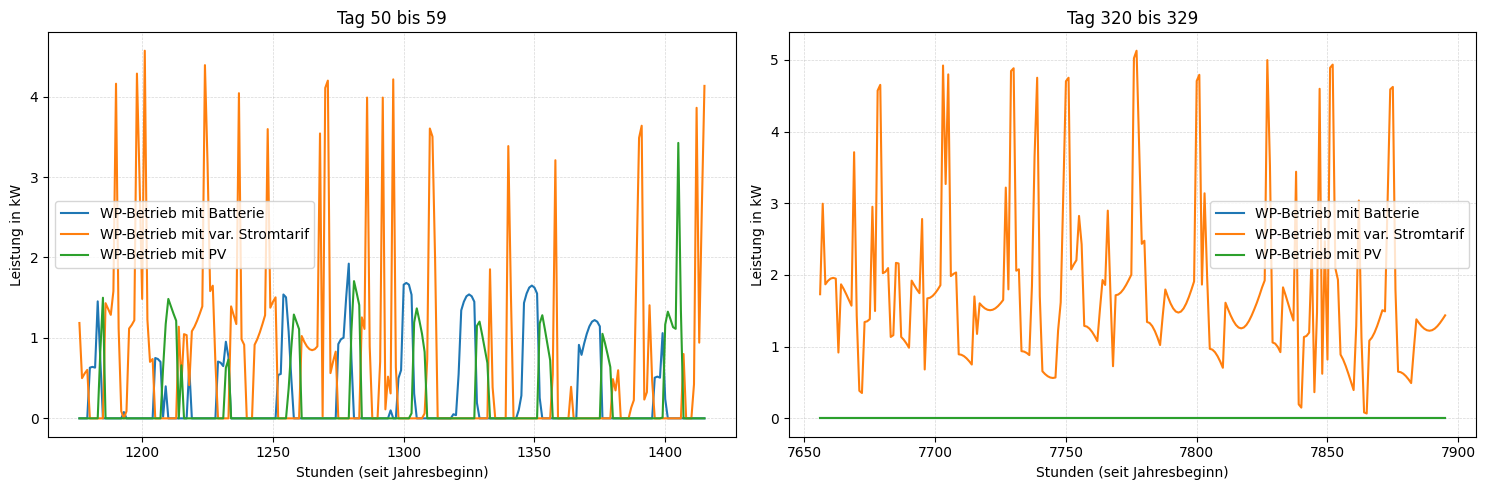

In [55]:
# Datenvorbereitung
data = {
    'Zeit': list(range(T)),
    'Wärmepumpe': [P[t].varValue for t in range(T)],
    'Pufferspeicher': [S[t].varValue for t in range(T)],
    'Einspeisung': [x_in[t].varValue for t in range(T)],
    'Entnahme': [x_out[t].varValue for t in range(T)],
    'Stromdeckung Anbieter': [y_pur[t].varValue for t in range(T)],
    'Stromdeckung mit PV': [y_pv_self[t].varValue for t in range(T)],
    'Stromdeckung Haus mit Batterie': [y_s_dc_home[t].varValue for t in range(T)],
    'Stromverkauf von PV': [y_pv_feedin[t].varValue for t in range(T)],
    'Laden Batterie mit PV': [y_s_ch[t].varValue for t in range(T)],
    'Entladen Batterie': [y_s_dc[t].varValue for t in range(T)],
    'Batteriefüllstand': [l_s[t].varValue for t in range(T)],
    'WP-Betrieb mit Batterie' : [y_heat_bat[t].varValue for t in range(T)],
    'WP-Betrieb mit PV' : [y_heat_pv[t].varValue for t in range(T)],
    'WP-Betrieb mit var. Stromtarif' : [y_heat_pur[t].varValue for t in range(T)],
}

df_final = pd.DataFrame(data)

# Input gewünschter Zeitraum
day_left =
day_right = 320
days = 10

if days == 1: day_safe = f"Tag {day_left}"
else: day_safe = f"Tag {day_left} bis {day_left + days - 1}"

if days == 1: day_safe_1 = f"Tag {day_right}"
else: day_safe_1 = f"Tag {day_right} bis {day_right + days - 1}"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df_final[(day_left - 1) * 24:((day_left - 1) * 24) + days * 24 ][["WP-Betrieb mit Batterie", "WP-Betrieb mit var. Stromtarif", "WP-Betrieb mit PV"]].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_xlabel("Stunden (seit Jahresbeginn)")
ax1.set_title(day_safe)
ax1.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

df_final[(day_right - 1) * 24:((day_right - 1) * 24) + days * 24 ][["WP-Betrieb mit Batterie", "WP-Betrieb mit var. Stromtarif", "WP-Betrieb mit PV"]].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_xlabel("Stunden (seit Jahresbeginn)")
ax2.set_title(day_safe_1)
ax2.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)

plt.tight_layout()
plt.show()

## Kostenvergleich von getrennten Systemen und Systemintegration

- Kosteneinsparung als Säulendiagramm zur vereinfachten Übersicht

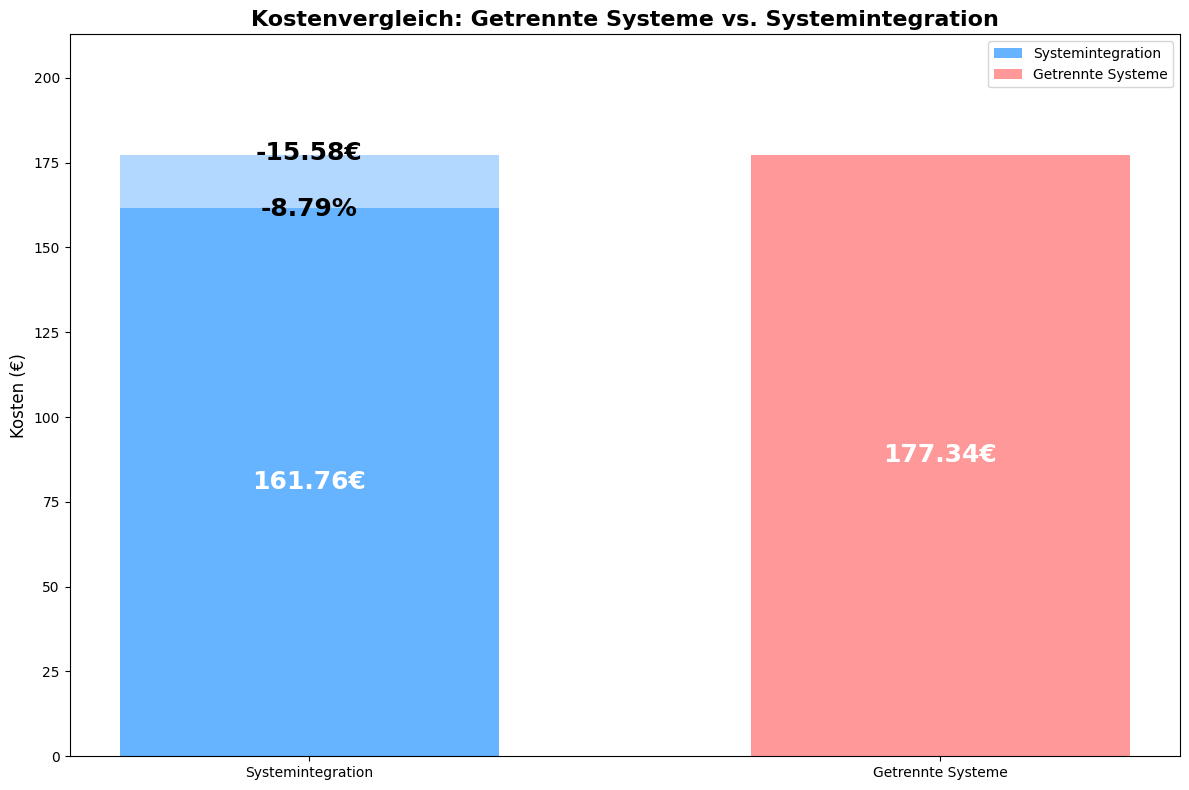

In [37]:
# Werte
kosten_systemintegration = round(p.value(model.objective), 2)
kosten_getrennte_systeme = round(p.value(model_1.objective) + p.value(model_2.objective), 2)
einsparung = round(kosten_getrennte_systeme - kosten_systemintegration, 2)
einsparung_prozent = round((einsparung / kosten_getrennte_systeme) * 100, 2)

# Daten für das Säulendiagramm
labels = ['Systemintegration', 'Getrennte Systeme']
x = np.arange(len(labels))  # Position der Balken
width = 0.6  # Breite der Balken

fig, ax = plt.subplots(figsize=(12, 8))

bars_new = ax.bar(x[0], kosten_systemintegration, width, color='#66b3ff', label='Systemintegration')
bars_savings = ax.bar(x[0], einsparung, width, bottom=kosten_systemintegration, color='#66b3ff', alpha=0.5)
bars_old = ax.bar(x[1], kosten_getrennte_systeme, width, color='#ff9999', label='Getrennte Systeme')

ax.text(x[0], kosten_systemintegration / 2, f'{kosten_systemintegration}€', ha='center', va='center', fontsize=18, color='white', fontweight='bold')
ax.text(x[0], kosten_systemintegration + (einsparung / 2), f'-{einsparung}€\n\n-{einsparung_prozent}%', ha='center', va='center', fontsize=18, color='black', fontweight='bold')
ax.text(x[1], kosten_getrennte_systeme / 2, f'{kosten_getrennte_systeme}€', ha='center', va='center', fontsize=18, color='white', fontweight='bold')
ax.set_ylabel('Kosten (€)', fontsize=12)
ax.set_title('Kostenvergleich: Getrennte Systeme vs. Systemintegration', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_ylim(0, kosten_getrennte_systeme * 1.2)# Begrenzen der x-Achse für eine bessere Darstellung
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()


## Übersicht zu Eigenverbrauch & Autarkie
- die Eigenverbrauchsquote besagt wie viel Prozent der gesamt erzeugten PV-Leistung selbst genutzt wird
- die Autarkiequote gibt an wie viel Prozent des eigenen Energiebedarfs durch PV-Leistung gedeckt wird

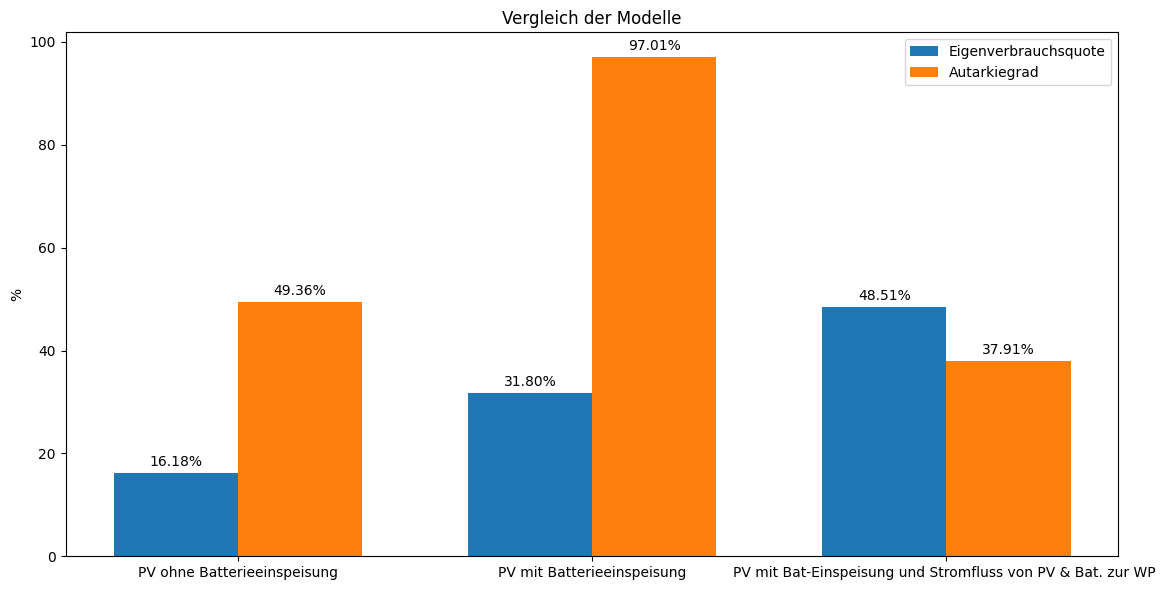

In [39]:
# Daten für die Modelle
eigenverbrauch = df_basis["Strombezug PV"].sum()
eigenverbrauchsquote_1 = eigenverbrauch / df_2019['pv'].sum() * 100
autarkiegrad_1 = eigenverbrauch / df_2019['demand'].sum() * 100
eigenverbrauch = df_final["Stromdeckung mit PV"].sum()
eigenverbrauchsquote_2 = eigenverbrauch / df_2019['pv'].sum() * 100
autarkiegrad_2 = eigenverbrauch / (df_2019['demand'].sum() + sum(Q_ges)) * 100

modelle = ['PV ohne Batterieeinspeisung', 'PV mit Batterieeinspeisung', 'PV mit Bat-Einspeisung und Stromfluss von PV & Bat. zur WP ']

Eigenverbrauchsquote = [eigenverbrauchsquote, eigenverbrauchsquote_1, eigenverbrauchsquote_2]
Autarkiegrad = [autarkiegrad, autarkiegrad_1, autarkiegrad_2]

# Layout
x = np.arange(len(modelle))
breite = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

balken1 = ax.bar(x - breite/2, Eigenverbrauchsquote, breite, label='Eigenverbrauchsquote')
balken2 = ax.bar(x + breite/2, Autarkiegrad, breite, label='Autarkiegrad')

ax.set_ylabel('%')
ax.set_title('Vergleich der Modelle')
ax.set_xticks(x)
ax.set_xticklabels(modelle)
ax.legend()

# Fügt Werte überhalb der Balken ein
def add_labels(balken):
    for balk in balken:
        height = balk.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(balk.get_x() + balk.get_width() / 2, height),
                    xytext=(0, 3),  # 3 Punkte vertikal versetzen
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(balken1)
add_labels(balken2)
fig.tight_layout()
plt.show()


## Grafik zur Amortisationsdauer
- Die Grafik verdeutlicht die Amortisations- und Gewinnphase


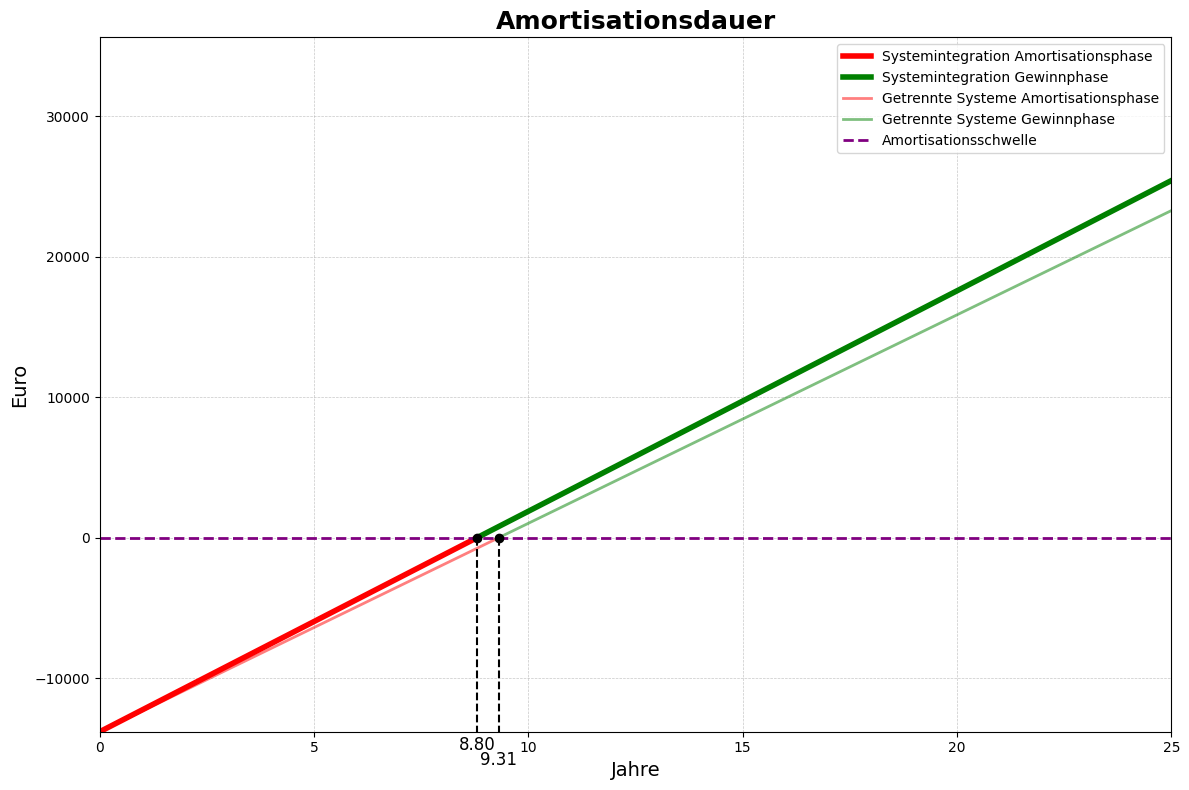


Die Amortisationsdauer wird durch die Integrierung der Systeme von 9.31 Jahre auf 8.8 Jahre verkürzt.
Das sind 0.51 Jahre weniger, im Vergleich zu dem getrenntem Modell, daraus folgt eine Verbesserung von 8.36 %.


In [86]:
# Input Werte
cost = p.value(model.objective)
cost1 = p.value(model_1.objective)
buy_cost = buy_pump + buy_storage

def gerade(x, m):
    return m * x - buy_cost

y_schnitt = buy_cost

steigung1 = heating_bill - cost
steigung2 = heating_bill - cost1

# Sicherstellen, dass steigung1 und steigung2 nicht null sind
if steigung1 == 0 or steigung2 == 0:
    raise ValueError("Steigung darf nicht null sein.")

x_schnitt1 = y_schnitt / steigung1
x_schnitt2 = y_schnitt / steigung2

x_total = np.linspace(0, 30, 300)

# Segmente für Gerade 1
mask_rot = x_total <= x_schnitt1
x_rot1 = x_total[mask_rot]
y_rot1 = gerade(x_rot1, steigung1)

mask_gruen = x_total > x_schnitt1
x_gruen1 = x_total[mask_gruen]
y_gruen1 = gerade(x_gruen1, steigung1)

# Segmente für Gerade 2
mask_rot2 = x_total <= x_schnitt2
x_rot2 = x_total[mask_rot2]
y_rot2 = gerade(x_rot2, steigung2)

mask_gruen2 = x_total > x_schnitt2
x_gruen2 = x_total[mask_gruen2]
y_gruen2 = gerade(x_gruen2, steigung2)

# Erstellen des Diagramms
fig, ax = plt.subplots(figsize=(12, 8))

# Zeichnen der Segmente der ersten Geraden
ax.plot(x_rot1, y_rot1, color='red', linewidth=4, label='Systemintegration Amortisationsphase')
ax.plot(x_gruen1, y_gruen1, color='green', linewidth=4, label='Systemintegration Gewinnphase')

# Zeichnen der Segmente der zweiten Geraden mit gleichen Farben und Markern
ax.plot(x_rot2, y_rot2, color='red', linewidth=2, alpha=0.5, label='Getrennte Systeme Amortisationsphase')
ax.plot(x_gruen2, y_gruen2, color='green', linewidth=2, alpha=0.5, label='Getrennte Systeme Gewinnphase')

# Hinzufügen der horizontalen Linie bei y=0
ax.axhline(y=0, color='purple', linestyle='--', linewidth=2, label='Amortisationsschwelle')

# Markieren der Schnittpunkte auf der X-Achse
ax.plot(x_schnitt1, 0, marker='o', color='black')
ax.plot(x_schnitt2, 0, marker='o', color='black')

# Zeichnen der senkrechten gestrichelten Linien von den Schnittpunkten zur horizontalen Linie
ax.vlines(x_schnitt1, ymin=0, ymax=-buy_cost, colors='black', linestyles='dashed')
ax.vlines(x_schnitt2, ymin=0, ymax=-buy_cost, colors='black', linestyles='dashed')

# Beschriften der X-Werte an den Schnittpunkten auf der X-Achse
ax.text(x_schnitt1, -buy_cost*1.02, f'{x_schnitt1:.2f}', ha='center', va='top', fontsize=12, color='black')
ax.text(x_schnitt2, -buy_cost*1.1, f'{x_schnitt2:.2f}', ha='center', va='top', fontsize=12, color='black')

# Achsenbeschriftungen und Titel
ax.set_xlabel('Jahre', fontsize=14)
ax.set_ylabel('Euro', fontsize=14)
ax.set_title('Amortisationsdauer', fontsize=18, fontweight='bold')
ax.set_xlim(0, 25)
ax.set_ylim(bottom=-buy_cost)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()

print()
print("Die Amortisationsdauer wird durch die Integrierung der Systeme von", round(buy_cost / (heating_bill - cost1),2) ,"Jahre auf", round(buy_cost / (heating_bill - cost),2) ,"Jahre verkürzt.")
print("Das sind", round((buy_cost / (heating_bill - cost1)) - (buy_cost / (heating_bill - cost)), 2), "Jahre weniger, im Vergleich zu dem getrenntem Modell, daraus folgt eine Verbesserung von", round(((buy_cost / (heating_bill - cost1)) - (buy_cost / (heating_bill - cost)) / (buy_cost / (heating_bill - cost1))), 2), "%.")